# Final Project Submission
---

## Info

* Student name: **Barto Molina**
* Student pace: **part time**
* Scheduled project review date/time: **06/20/2019 4:30 PM (EST)**
* Instructor name: **Victor Geislinger**
* Blog post URL: 

## Imports

Load the required libraries that will be used throughout the rest of the project:

In [48]:
# we use dotenv to use CARTO API key: https://carto.com/signup/
# use .env.example as a reference
import os
from dotenv import load_dotenv
load_dotenv()

# CARTOframes imports
import cartoframes
from cartoframes import Credentials, Layer, styling

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Load the dataset from [kc_house_data.csv](kc_house_data.csv):

In [49]:
df = pd.read_csv('kc_house_data.csv')

## Data / Project Summary

The column descriptions can be found in the [column_names.md](column_names.md) file.

Let's have a first look of the data by looking at the number of records, data types and the values of the first few rows of the dataset:

In [15]:
df.info()

# display all columns
pd.set_option('display.max_columns', 21)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
0      5650     1.0         NaN   0.0          3      7        1180   
1      7242     2.0         0.0   0.0          3      7        2170   
2     10000     1.0         0.0   0.0          3      6         770   
3      5000     1.0         0.0   0.0          5      7        1050   
4      8080     1.0         0.0   0.0          3      8        1680   

  sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
0           0.0      1955           0.0    98178  47.5112 -122.257   
1         400.0      1951        1991.0    98125  47.7210 -122.319   
2           0.0      1933           NaN    98028  47.7379 -122.233   
3         910.0      1965           0.0    98136  47.5208 -122.393   
4           0.0      1987           0.0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503

Let's look at the first three columns of the data:

- id: unique identified for a house
- date: the date the house was sold
- price: this is our target variable


Let's find out what's the date range for the data and see if we can use the id column as the index for our dataset:

In [16]:
# date range
print(f"{df.date.max()} - {df.date.min()}")

9/9/2014 - 1/10/2015


In [17]:
# return the rows with a duplicated id (same property) and order by id
df[df.duplicated(['id'], keep=False)].sort_values(by='id').head()

id        date     price  bedrooms  bathrooms  sqft_living  \
2495     1000102   4/22/2015  300000.0         6       3.00         2400   
2494     1000102   9/16/2014  280000.0         6       3.00         2400   
16800    7200179  10/16/2014  150000.0         2       1.00          840   
16801    7200179   4/24/2015  175000.0         2       1.00          840   
11422  109200390  10/20/2014  250000.0         3       1.75         1480   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
2495       9373     2.0         0.0   0.0          3      7        2400   
2494       9373     2.0         NaN   0.0          3      7        2400   
16800     12750     1.0         0.0   0.0          3      6         840   
16801     12750     1.0         0.0   0.0          3      6         840   
11422      3900     1.0         0.0   0.0          4      7        1480   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
2495            0.0      1991           0.0    98002  47.3262 -122.214   
2494            0.0      1991           0.0    98002  47.3262 -122.214   
16800           0.0      1925           0.0    98055  47.4840 -122.211   
16801           0.0      1925           NaN    98055  47.4840 -122.211   
11422           0.0      1980           0.0    98023  47.2977 -122.367   

       sqft_living15  sqft_lot15  
2495            2060        7316  
2494            2060        7316  
16800           1480        6969  
16801           1480        6969  
11422           1830        6956

**Observations**

- The dataset contains 21,597 rows which represent houses sold in King County (Washington) from September, 2014 to October, 2015. The [current population](https://suburbanstats.org/population/washington/how-many-people-live-in-king-county) (total number of houses in KC in 2019) is 789,232, and given that the population hasn't increased significantly from 2015 to 2019, we can assume that we're working with a sample of around 3% of the total number of properties in KC (although whether that's the total number of sales during that period is unknown).

- `price` is the target variable. From the set of variables, we'll try to identify those with a higher influence over the price, which we'll use to build our model.

- The `id` column identifies each house, and not a sale record. Hence this might be useful in order to fill in incomplete data (those features that will be necessarily equal) and use this feature to test the validity of the date as a predictor.

## 1. Data Scrubbing

### First look at the dataset

Before we start the data scrubbing process by dealing with null values and data types, let's have a quick look at the scatter plot and histogram for all the variables. This will help us identify correlations between our features, determine the skeweness and curtosis and point to possible outliers

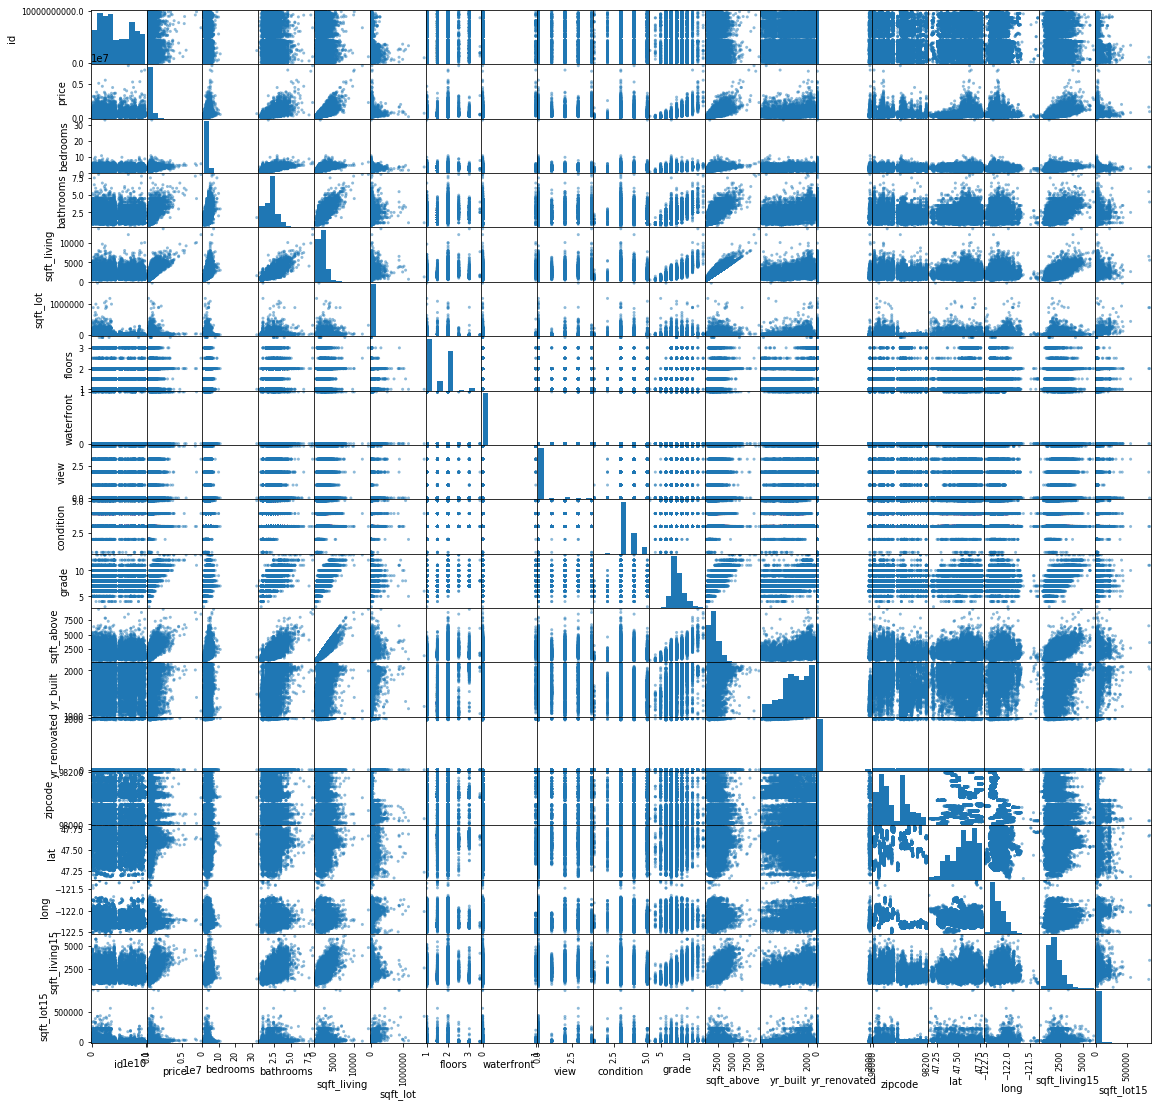

In [18]:
pd.plotting.scatter_matrix(df, figsize  = [19, 19]);

In [19]:
df.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.159700e+04  2.159700e+04  21597.000000  21597.000000  21597.000000   
mean   4.580474e+09  5.402966e+05      3.373200      2.115826   2080.321850   
std    2.876736e+09  3.673681e+05      0.926299      0.768984    918.106125   
min    1.000102e+06  7.800000e+04      1.000000      0.500000    370.000000   
25%    2.123049e+09  3.220000e+05      3.000000      1.750000   1430.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.159700e+04  21597.000000  19221.000000  21534.000000  21597.000000   
mean   1.509941e+04      1.494096      0.007596      0.233863      3.409825   
std    4.141264e+04      0.539683      0.086825      0.765686      0.650546   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.040000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.618000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.068500e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above      yr_built  yr_renovated       zipcode  \
count  21597.000000  21597.000000  21597.000000  17755.000000  21597.000000   
mean       7.657915   1788.596842   1970.999676     83.636778  98077.951845   
std        1.173200    827.759761     29.375234    399.946414     53.513072   
min        3.000000    370.000000   1900.000000      0.000000  98001.000000   
25%        7.000000   1190.000000   1951.000000      0.000000  98033.000000   
50%        7.000000   1560.000000   1975.000000      0.000000  98065.000000   
75%        8.000000   2210.000000   1997.000000      0.000000  98118.000000   
max       13.000000   9410.000000   2015.000000   2015.000000  98199.000000   

                lat          long  sqft_living15     sqft_lot15  
count  21597.000000  21597.000000   21597.000000   21597.000000  
mean      47.560093   -122.213982    1986.620318   12758.283512  
std        0.138552      0.140724     685.230472   27274.441950  
min       47.155900   -122.519000     399.000000     651.000000  
25%       47.471100   -122.328000    1490.000000    5100.000000  
50%       47.571800   -122.231000    1840.000000    7620.000000  
75%       47.678000   -122.125000    2360.000000   10083.000000  
max       47.777600   -121.315000    6210.000000  871200.000000

In [20]:
df.isnull().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

**Observations**

1. Categorical data

From the scatter matrix above, we've identified the following features that can be considered as **categorical**:

- waterfront
- view
- condition
- grade

We'll consider `bedrooms` and `floors` as quantitative, assuming there's a mathematical relationship between the values on these columns, and will transform the rest of the columns into categories.

We'll also consider `zipcode` and the years (`yr_built` and `yr_renovated`) as categorical.

2. Null values

There are some columns with null values (`waterfront`, `view` and `yr_renovated`). For `waterfront` and `yr_renovated` this is number is relevant (around 10% of the data) and we'll need to decide how we handle them. As for the `view` column, we'll probably just drop those 63 records. We'll also need to look for placeholders.

3. Outliers and placeholders

From the summary table, we can note a couple of clear outliers on the max. values of the number of bedrooms (33) and the house footage / lot footage (13540 / 1651359) and a value of 0 in the `yr_renovated` which might be used as a placeholder

### Null values / placeholders and data types

After an initial exploration, we found that the `waterfront`, `view` and `yr_renovated` contain null values. Before dealing with them, we'll also check if there are values that may be used placeholders in any of the columns:

In [50]:
for column in df:
    print(column)
    print('-----------')
    print('describe:')
    print(df[column].describe())
    print('unique values:')
    print(df[column].unique())
    print('value counts:')
    print(df[column].value_counts(dropna = False).head())
    print('\n')

price
-----------
describe:
count    2.159600e+04
mean     5.402920e+05
std      3.673760e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64
unique values:
[221900. 538000. 180000. ... 541800. 610685. 402101.]
value counts:
350000.0    172
450000.0    172
550000.0    159
500000.0    152
425000.0    150
Name: price, dtype: int64


bedrooms
-----------
describe:
count    21596.000000
mean         3.371828
std          0.904114
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: bedrooms, dtype: float64
unique values:
[ 3  2  4  5  1  6  7  8  9 11 10]
value counts:
3    9824
4    6882
2    2760
5    1601
6     272
Name: bedrooms, dtype: int64


bathrooms
-----------
describe:
count    21596.000000
mean         2.115843
std          0.768998
min          0.500000
25%          1.750000
50%          2.250000
75%          2.500000
max     

The following columns contain null values / placeholders:
- `waterfront`: 'nan' (2376)
- `view`: 'nan' (63)
- `sqft_basement`: '?' (454)
- `yr_renovated`: '0.0' (17011), 'nan' (3842)

We'll deal with the null values / placeholders for each of the columns individually:

#### Waterfront

Let's have a look at the Waterfront column. From the `value_counts`, we can see that the majority of the houses are not waterfront. There are many null values compared to the number of the houses that are waterfront:

In [22]:
df.waterfront.value_counts(dropna=False)

0.0    19075
NaN     2376
1.0      146
Name: waterfront, dtype: int64

 We might assume that these houses are not waterfront but first, let's compare the price for all the categories with box plots:

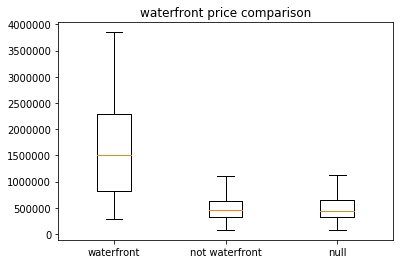

In [23]:
# show a box plot with the three categories of waterfront: 1, 0, null
wf_prices = []
wf_prices.append(df[df['waterfront'] == 1.0].price)
wf_prices.append(df[df['waterfront'] == 0.0].price)
wf_prices.append(df[df['waterfront'].isna()].price)

plt.title('waterfront price comparison')
plt.boxplot(wf_prices, labels=['waterfront', 'not waterfront', 'null'], showfliers=False);

Indeed, it seems that the price of the waterfront houses is higer than the one that are not facing the river. The null values seem to correspond to houses that are not facing the river.

In [50]:
# replace the null values in the waterfront column with '0'
df['waterfront'].fillna(0, inplace=True)

#### View

This column indicates if the house has been viewed. It's not clear what this column represents, but we'll assume that is the number of times a house has been viewed by a buyer before closing the transaction. Following a similar approach as with the `waterfront` column, we're going to see if theres any difference between the values in this column in relation with the price using box plots:

In [25]:
df.view.unique()

array([ 0., nan,  3.,  4.,  2.,  1.])

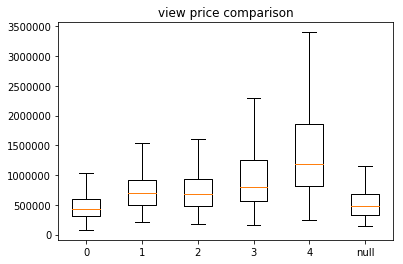

In [26]:
# show a box plot with the six categories of view: 0, 1, 2, 3, 4, null
vw_prices = []
vw_prices.append(df[df['view'] == 0.0].price)
vw_prices.append(df[df['view'] == 1.0].price)
vw_prices.append(df[df['view'] == 2.0].price)
vw_prices.append(df[df['view'] == 3.0].price)
vw_prices.append(df[df['view'] == 4.0].price)
vw_prices.append(df[df['view'].isna()].price)

plt.title('view price comparison')
plt.boxplot(vw_prices, labels=['0', '1', '2', '3', '4', 'null'], showfliers=False);

We can assume that the null values correspond to houses that have not been viewed.

In [51]:
# replace the null values in the waterfront column with '0'
df['view'].fillna(0, inplace=True)

#### Basement footage 

Let's investigate if there's any relationship between the different `square footage` columns:

In [28]:
# create a new dataframe that contains all the sqft related columns
cols = [col for col in df.columns if 'sqft' in col]
df_sqft = df[cols].copy()

df_sqft[df['sqft_basement'] != '?'].head(10)

sqft_living  sqft_lot  sqft_above sqft_basement  sqft_living15  sqft_lot15
0          1180      5650        1180           0.0           1340        5650
1          2570      7242        2170         400.0           1690        7639
2           770     10000         770           0.0           2720        8062
3          1960      5000        1050         910.0           1360        5000
4          1680      8080        1680           0.0           1800        7503
5          5420    101930        3890        1530.0           4760      101930
7          1060      9711        1060           0.0           1650        9711
8          1780      7470        1050         730.0           1780        8113
9          1890      6560        1890           0.0           2390        7570
10         3560      9796        1860        1700.0           2210        8925

It seems that the `sqft_basement` is actually the difference between the `sqft_living` and the `sqft_above` columns. Let's verify:

In [51]:
# all the houses with a basement
df_basement = df_sqft[df_sqft['sqft_basement'] != '?'].copy()

# create a calculated basement sqft column as sqft_living - sqft_above
df_basement['sqft_basement_calculated'] = df_basement['sqft_living'] - df_basement['sqft_above']

In [52]:
# convert the 'sqft_basement' column to int and check if the calculate values match the actual existing values
df_basement['sqft_basement'] = pd.to_numeric(df_basement['sqft_basement'], downcast='integer')

# compare calculated and actual values
(df_basement['sqft_basement'] == df_basement['sqft_basement_calculated']).all()

True

They match! For now, we'll just assume that the sqft_basement is just the difference between the `sqft_living` and the `sqft_above`. We'll convert the `sqft_basement` into int and then we'll fill in the nulls with the calculated value:

In [52]:
df['sqft_basement'].replace('?', np.nan, inplace=True)
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'], downcast='integer')
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']

We suspect that these columns will present some type of correlation and we'll need to drop some of them.

#### Year renovated

The `yr_renovated = 0` may indicate that the house has never been renovated, and we could assume that the null values also indicate that the house is not renovated. Same as with the `waterfront` and the `view` coulmns, let's inpect the relationship with the target value using box plots:

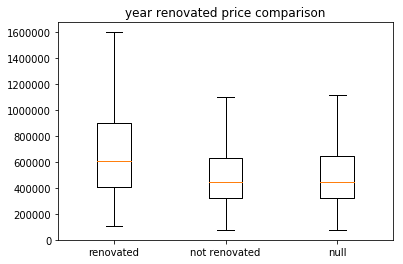

In [32]:
# show a box plot with the three categories of yr_renovated: 0, null, renovated
rn_prices = []
rn_prices.append(df[(df['yr_renovated'] != 0.0) & (df['yr_renovated'].notna())].price)
rn_prices.append(df[df['yr_renovated'] == 0.0].price)
rn_prices.append(df[df['yr_renovated'].isna()].price)

plt.title('year renovated price comparison')
plt.boxplot(rn_prices, labels=['renovated', 'not renovated', 'null'], showfliers=False);

Also in this case we can assume that both the null values and '0' correspond to houses that haven't been renovated, and we'll convert the '0' values into nulls:

In [53]:
# replace the null values in the yr_renovated column with '0'
df['yr_renovated'].replace(0, np.nan, inplace=True)

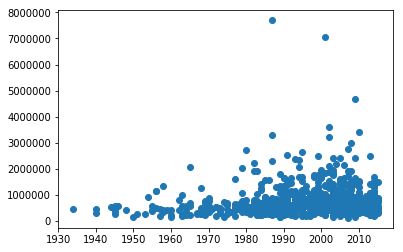

In [34]:
plt.scatter(df.yr_renovated, df.price);

#### Future work

- Fill in data based on duplicated ids (as it's the same house)
- Analize the date column

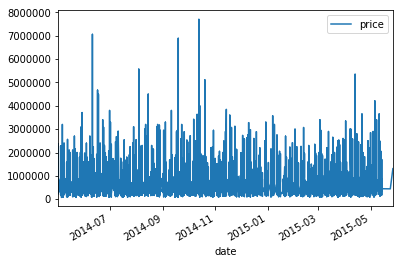

In [35]:
df['date'] = df['date'].astype('datetime64')
df.plot(x='date', y='price');

### Outliers

As discussed, we've identified some outliers in the `sqft_living` / `sqft_lot` and `bedrooms` columns. For now, we're going to remove the house with 33 bedrooms as it clearly seems related to an error during the data input:

In [36]:
df[df.bedrooms == 33]

id       date     price  bedrooms  bathrooms  sqft_living  \
15856  2402100895 2014-06-25  640000.0        33       1.75         1620   

       sqft_lot  floors  waterfront  view  condition  grade  sqft_above  \
15856      6000     1.0         0.0   0.0          5      7        1040   

       sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
15856            580      1947           NaN    98103  47.6878 -122.331   

       sqft_living15  sqft_lot15  
15856           1330        4700

In [54]:
df = df[df.bedrooms != 33]

#### Future work

- investigate additional possible outliers: house footage / lot footage (13540 / 1651359 max)

### Multicollinearity

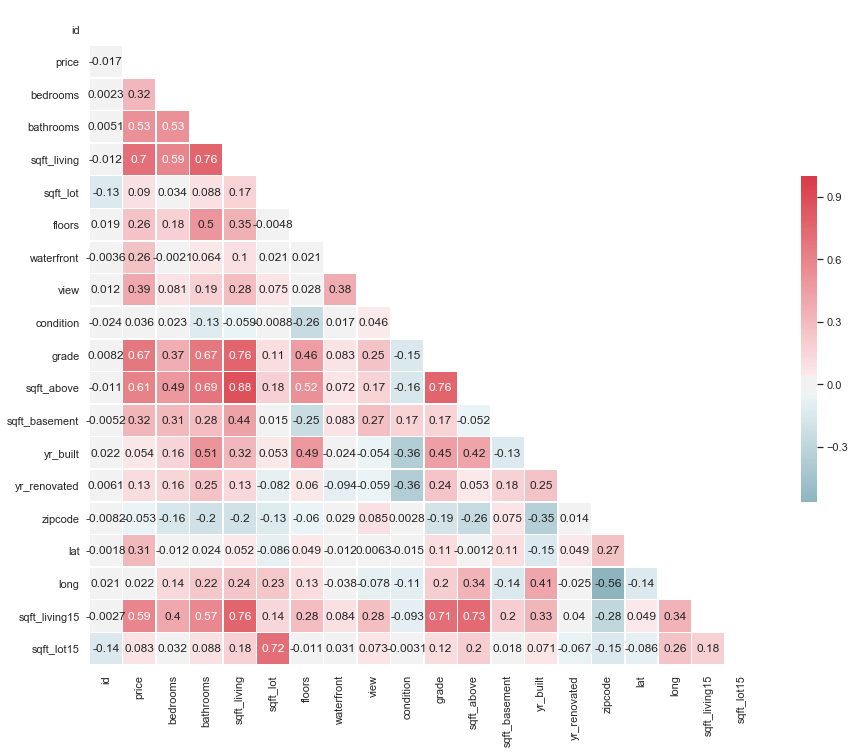

In [38]:
sns.set(style="white")
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0, mask=mask, linewidths=.5, annot=True, cbar_kws={"shrink": .5});

From the heatmap above, it seems that there may be a high correlation between:
- `sqft_living` and `bathrooms`
- `sqft_living`, `sqft_above` and `sqft_living15`
- `sqft_lot` and `sqft_lot15`

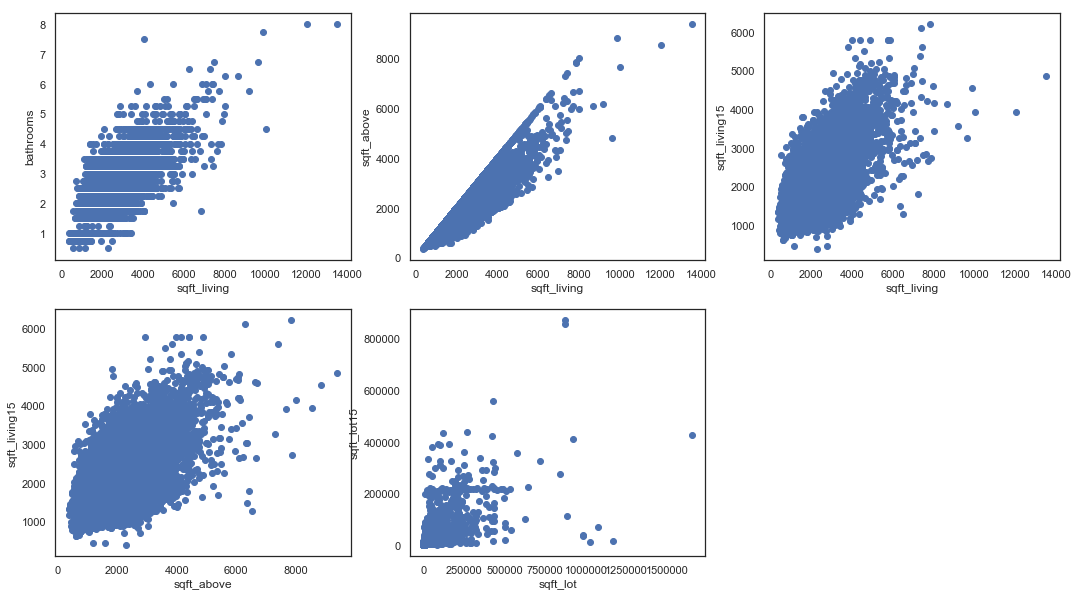

In [39]:
figure = plt.figure(figsize=(18, 10))
ax = figure.add_subplot(231)
ax2 = figure.add_subplot(232)
ax3 = figure.add_subplot(233)
ax4 = figure.add_subplot(234)
ax5 = figure.add_subplot(235)

ax.scatter(df['sqft_living'], df['bathrooms']);
ax.set_xlabel('sqft_living')
ax.set_ylabel('bathrooms')

ax2.scatter(df['sqft_living'], df['sqft_above']);
ax2.set_xlabel('sqft_living')
ax2.set_ylabel('sqft_above')

ax3.scatter(df['sqft_living'], df['sqft_living15']);
ax3.set_xlabel('sqft_living')
ax3.set_ylabel('sqft_living15')

ax4.scatter(df['sqft_above'], df['sqft_living15']);
ax4.set_xlabel('sqft_above')
ax4.set_ylabel('sqft_living15')

ax5.scatter(df['sqft_lot'], df['sqft_lot15']);
ax5.set_xlabel('sqft_lot')
ax5.set_ylabel('sqft_lot15')

plt.show()

As we suspected, there's a high correlation between the `sqft_living` and `sqft_above` columns. Also `sqft_living15` and `sqft_lot15` present some multicolliniarity.

We've decided to drop the `sqft_living` as it presents a high correlation with the rest of the columns. We'll also drop `sqft_living15` and `sqft_lot15`  which correlation with the target value is lower than the `sqft_above` and `sqft_lot` columns.

### Drop columns

Based on the investigations before, we're going to drop the following columns from the dataset:

- `id`, `date` and `view` as they won't provide relevant information for the model
- `sqft_living`, `sqft_living15` and `sqft_lot15` from the multicolliniarity test

In [55]:
df.drop(['id', 'date', 'view', 'sqft_living', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)

### Categorical features / One-hot encoding

As discussed before, the following columns will be converted into categories, so we'll transform them into strings:

In [56]:
# convert into categorical
df_cat = df.copy()
for column in ['waterfront', 'condition', 'grade', 'yr_renovated', 'yr_built', 'zipcode']:
        
# condition as quantitative:
# for column in ['waterfront', 'grade', 'yr_renovated', 'yr_built', 'zipcode']:

# remove zipcode:
# for column in ['waterfront', 'condition', 'grade', 'yr_renovated', 'yr_built']:

    df_cat[column] = df_cat[column].astype('str')

In [57]:
# create dummy variables
df_cat = pd.get_dummies(df_cat)

# rename problematic 'waterfront' and 'yr_renovated' columns
for column in df_cat.columns:
    if '.0' in column:
        renamed = column.replace('.0', '')
        df_cat.rename(columns={column: renamed}, inplace=True)

### Model validation: split the data

In [58]:
y = df_cat[['price']]
X = df_cat.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

### Normalization

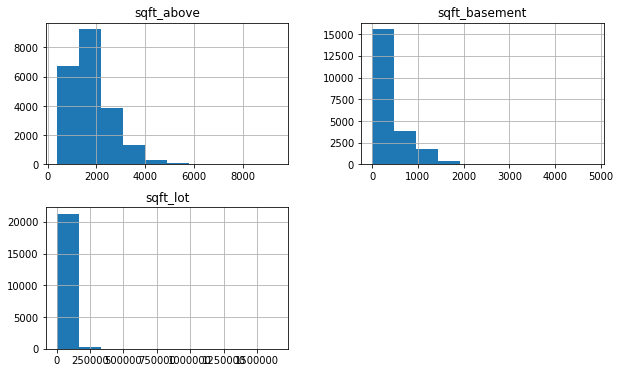

In [103]:
df[['sqft_above', 'sqft_basement', 'sqft_lot']].hist(figsize=(10,6));

Some columns present high positive skewness: `sqft_above`, `sqft_basement`, `sqft_lot` and the target variable `price`. We'll apply a log transformation to the former three for the time being:

In [59]:
# ignore SettingWithCopyWarning warnings
pd.set_option('mode.chained_assignment', None)

# apply transformations to train data
X_train['sqft_above'] = np.log(X_train['sqft_above'])
X_train['sqft_basement'] = np.log1p(X_train['sqft_basement'])
X_train['sqft_lot'] = np.log(X_train['sqft_lot'])
y_train['price'] = np.log(y_train['price'])

# apply transformations to test data
X_test['sqft_above'] = np.log(X_test['sqft_above'])
X_test['sqft_basement'] = np.log1p(X_test['sqft_basement'])
X_test['sqft_lot'] = np.log(X_test['sqft_lot'])
y_test['price'] = np.log(y_test['price'])

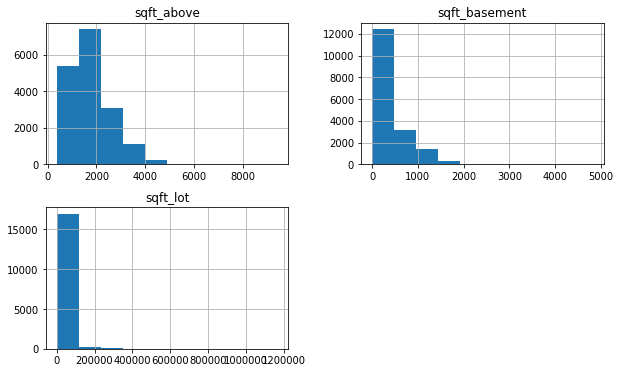

In [60]:
X_train[['sqft_above', 'sqft_basement', 'sqft_lot']].hist(figsize=(10,6));

## 2. EDA (Exploratory Data Analysis)

### Initial EDA

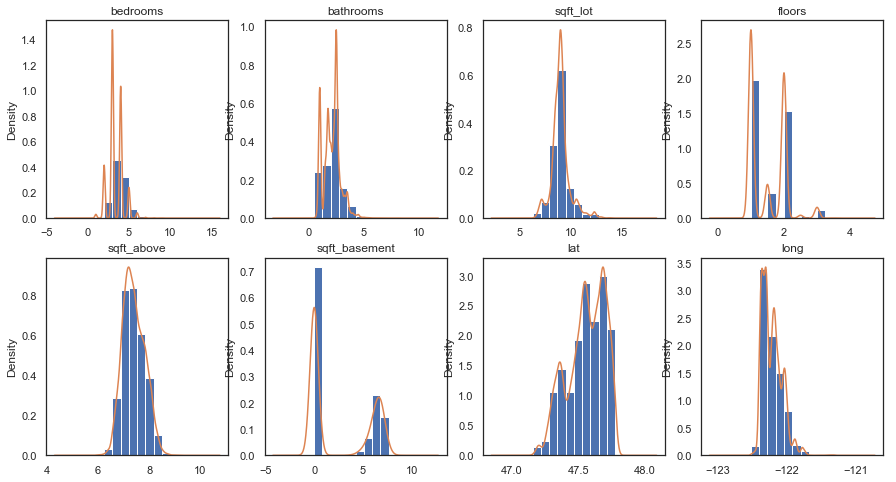

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,8))

for column in df_cat.iloc[:, 1:9].columns:
    i = df_cat.iloc[:, 0:9].columns.get_loc(column) - 1
    row = i//4
    col = i%4
    ax = axes[row, col]
    ax.hist(df_cat[column], density=True)
    df_cat[column].plot.kde(ax=ax)
    ax.set_title(column)
    
plt.show()

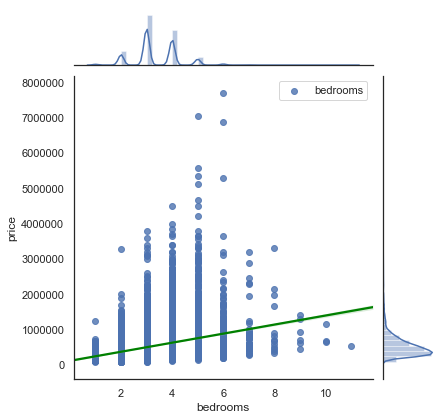

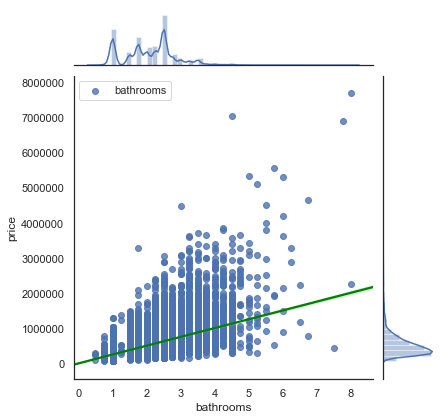

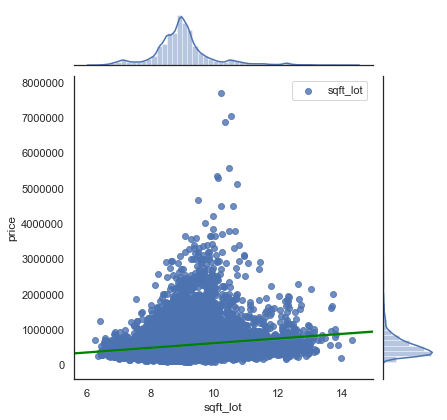

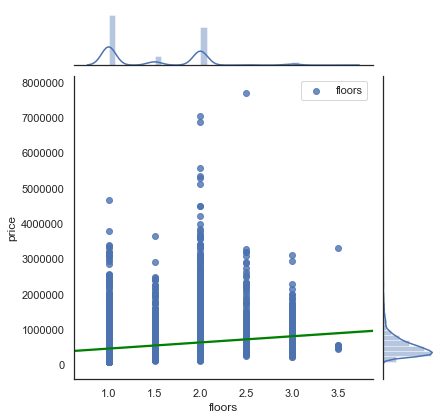

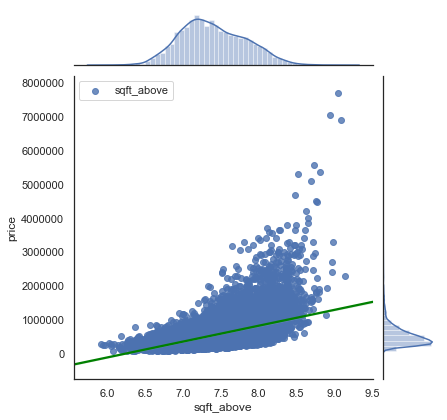

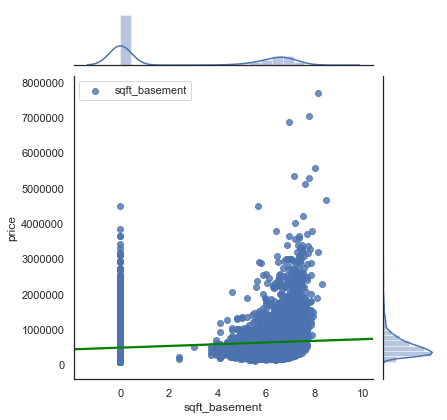

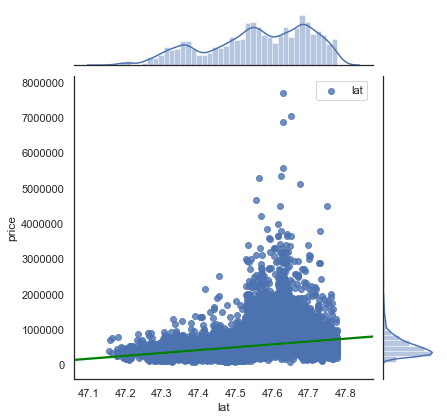

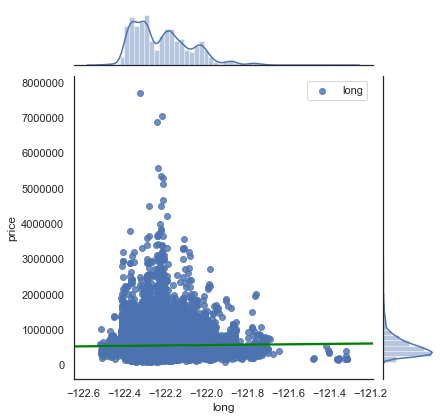

In [47]:
for column in df_cat.iloc[:, 1:9].columns:
    sns.jointplot(x=column, y='price',
                  data=df, 
                  kind='reg', 
                  label=column,
                  joint_kws={'line_kws':{'color':'green'}})
    plt.legend()
    plt.show()

### Mapping

In [88]:
USERNAME = os.getenv("CARTO_USERNAME")
APIKEY = os.getenv("CARTO_KEY")
creds = Credentials(username=USERNAME, 
                    key=APIKEY)
cc = cartoframes.CartoContext(creds=creds)

In [19]:
cc.write(df[['price', 'lat', 'long']],
         table_name='kc_house_data',
         lnglat=('long', 'lat'),
         overwrite=True)

Params: encode_geom, geom_col and everything in kwargs are deprecated and not being used any more


C:\Data\Python37\lib\site-packages\carto\sql.py:229: UserWarning: Batch SQL job created with job_id: 50cca0b4-ca1a-4d49-9fc5-b93e694952d5
  warnings.warn('Batch SQL job created with job_id: {job_id}'.format(job_id=data['job_id']))


Table successfully written to CARTO: https://bartomolina.carto.com/dataset/kc_house_data


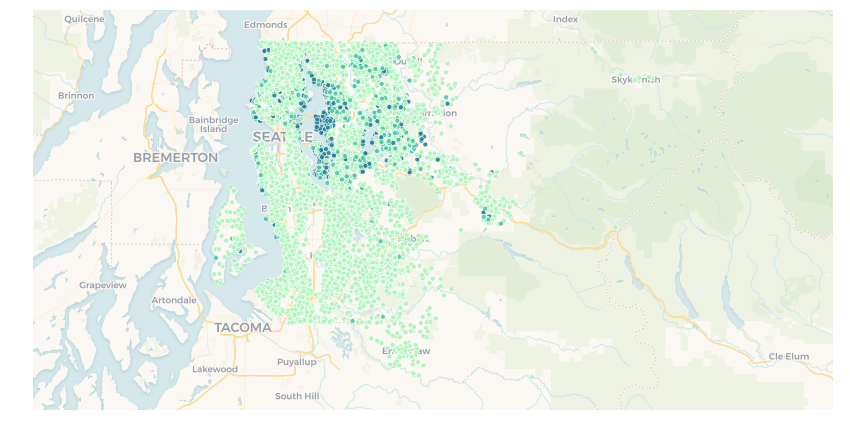

In [90]:
cc.map(layers=Layer('kc_house_data',
                    color={'column': 'price', 'scheme': styling.tealGrn(bins=3, bin_method='headtails')},
                    size=5), interactive=False)

## 3. Modeling

### Take 1

- **Quantitative features:** bedrooms, bathrooms, sqft_lot, floors, sqft_above, sqft_basement, lat, long
- **Categorical features:** waterfront, condition, grade, yr_renovated, yt_built, zipcode
- **Notes:** no normalization
- **Observatrions:** initial model
- **Results:**
  - $R^2 adj$: 0.828
  - MSE (train): 23326262785.647686
  - MSE (test): 21661260542.464382

In [14]:
X_train = X_train.drop(['waterfront_0', 'condition_1', 'grade_3', 'yr_renovated_1944', 'yr_built_1900', 'zipcode_98002'],
                       axis=1)
X_test = X_test.drop(['waterfront_0', 'condition_1', 'grade_3', 'yr_renovated_1944', 'yr_built_1900', 'zipcode_98002'],
                       axis=1)

In [15]:
predictors = sm.add_constant(X_train)
model = sm.OLS(y_train, predictors).fit()
model.summary()

# scikit learn
# linreg = LinearRegression()
# linreg.fit(predictors, y_train)

C:\Data\Python37\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     305.2
Date:                Sun, 16 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:01:27   Log-Likelihood:            -2.3073e+05
No. Observations:               17276   AIC:                         4.620e+05
Df Residuals:                   17002   BIC:                         4.641e+05
Df Model:                         273                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -3.404e+07    6.6e+06     -5.161      0.000    -4.7e+07   -2.11e+07
bedrooms          -1.798e+04   1791.883    -10.033      0.000   -2.15e+04   -1.45e+04
bathrooms          3.024e+04   2915.115     10.374      0.000    2.45e+04     3.6e+04
sqft_lot              0.2148      0.032      6.727      0.000       0.152       0.277
floors            -3.124e+04   3693.336     -8.458      0.000   -3.85e+04    -2.4e+04
sqft_above          175.6528      3.217     54.595      0.000     169.346     181.959
sqft_basement       135.4358      3.757     36.049      0.000     128.072     142.800
lat                1.516e+05   6.86e+04      2.209      0.027    1.71e+04    2.86e+05
long              -2.197e+05   4.87e+04     -4.515      0.000   -3.15e+05   -1.24e+05
waterfront_1       8.472e+05    1.5e+04     56.466      0.000    8.18e+05    8.77e+05
condition_2        6.754e+04   3.59e+04      1.879      0.060   -2900.891    1.38e+05
condition_3        8.143e+04   3.36e+04      2.424      0.015    1.56e+04    1.47e+05
condition_4        1.077e+05   3.36e+04      3.204      0.001    4.18e+04    1.74e+05
condition_5        1.486e+05   3.38e+04      4.396      0.000    8.23e+04    2.15e+05
grade_10            1.41e+05   1.56e+05      0.906      0.365   -1.64e+05    4.46e+05
grade_11           3.477e+05   1.56e+05      2.228      0.026    4.19e+04    6.54e+05
grade_12           7.577e+05   1.57e+05      4.827      0.000     4.5e+05    1.07e+06
grade_13           2.052e+06   1.64e+05     12.508      0.000    1.73e+06    2.37e+06
grade_4           -7.928e+04   1.59e+05     -0.499      0.618   -3.91e+05    2.32e+05
grade_5           -1.332e+05   1.56e+05     -0.855      0.393   -4.39e+05    1.72e+05
grade_6           -1.231e+05   1.55e+05     -0.792      0.429   -4.28e+05    1.82e+05
grade_7            -1.12e+05   1.55e+05     -0.721      0.471   -4.17e+05    1.93e+05
grade_8           -7.974e+04   1.56e+05     -0.513      0.608   -3.85e+05    2.25e+05
grade_9            6606.1638   1.56e+05      0.042      0.966   -2.98e+05    3.12e+05
yr_built_1901     -1.019e+05    3.6e+04     -2.828      0.005   -1.72e+05   -3.13e+04
yr_built_1902     -4.982e+04   3.73e+04     -1.336      0.182   -1.23e+05    2.33e+04
yr_built_1903     -3.039e+04    3.1e+04     -0.981      0.327   -9.11e+04    3.04e+04
yr_built_1904     -1.571e+04   3.16e+04     -0.497      0.619   -7.76e+04    4.62e+04
yr_built_1905      3.356e+04   2.79e+04      1.201      0.230   -2.12e+04    8.83e+04
yr_built_1906     -5004.5954   2.63e+04     -0.190      0.849   -5.65e+04    4.65e+04
yr_built_1907      2.304e+04   3.04e+04      0.757      0.449   -3.66e+04    8.27e+04
yr_built_1908     -1.817e+04   2.71e+04     -0.670      0.503   -7.13e+04     3.5e+04
yr_built_1909     -1.022e+04   2.73e+04     -0.375      0.708   -6.37e+04

In [16]:
predictors_test = sm.add_constant(X_test)
y_hat_train = model.predict(predictors)
y_hat_test = model.predict(predictors_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 23326262785.647686
Test Mean Squarred Error: 21661260542.464382


C:\Data\Python37\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


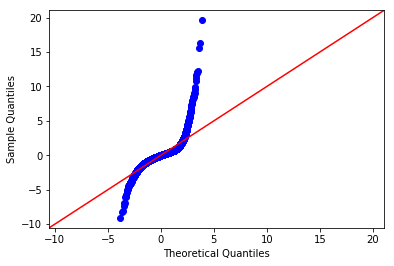

In [17]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

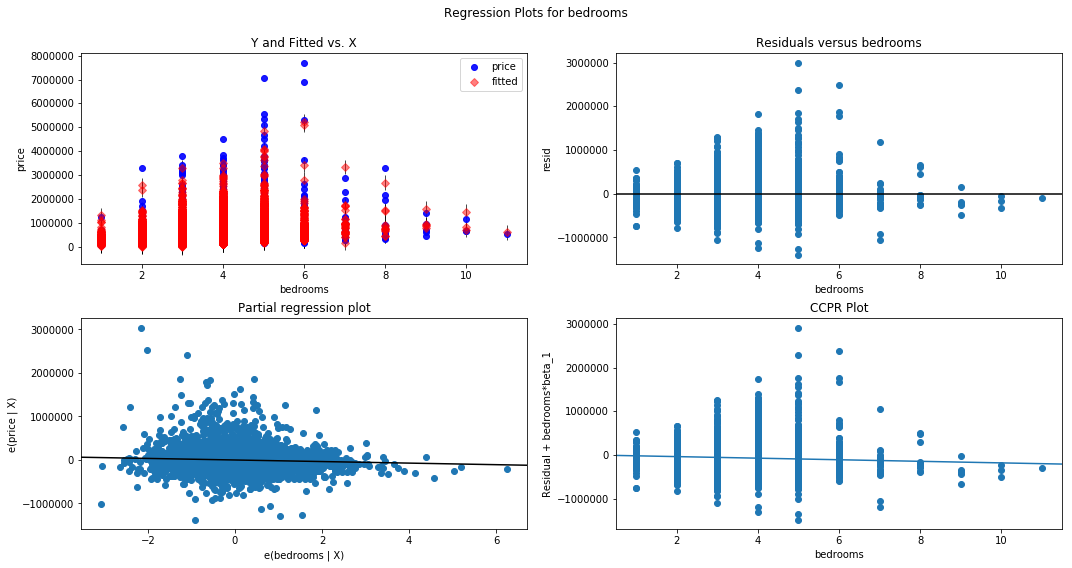

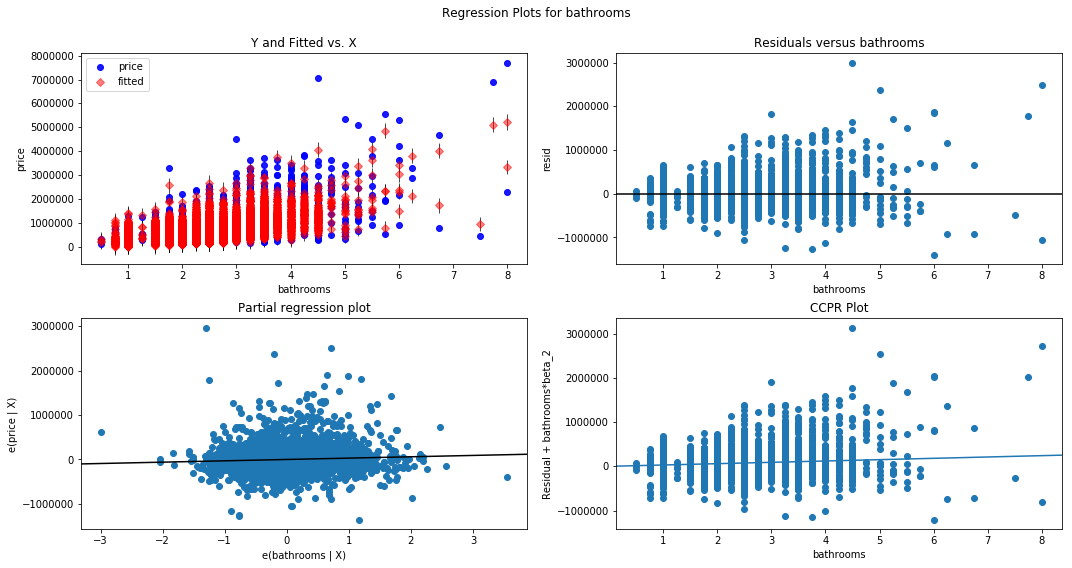

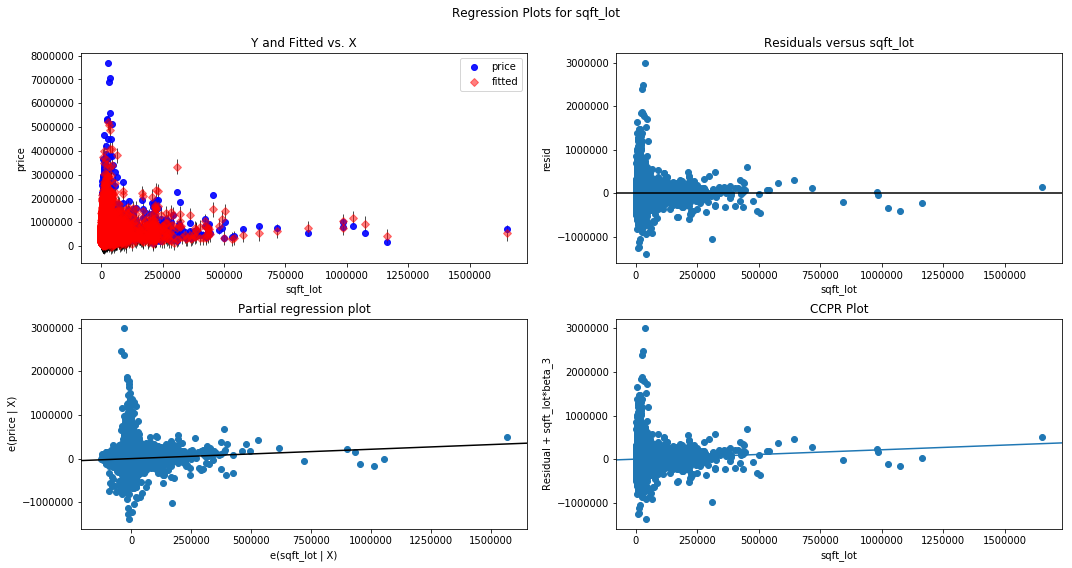

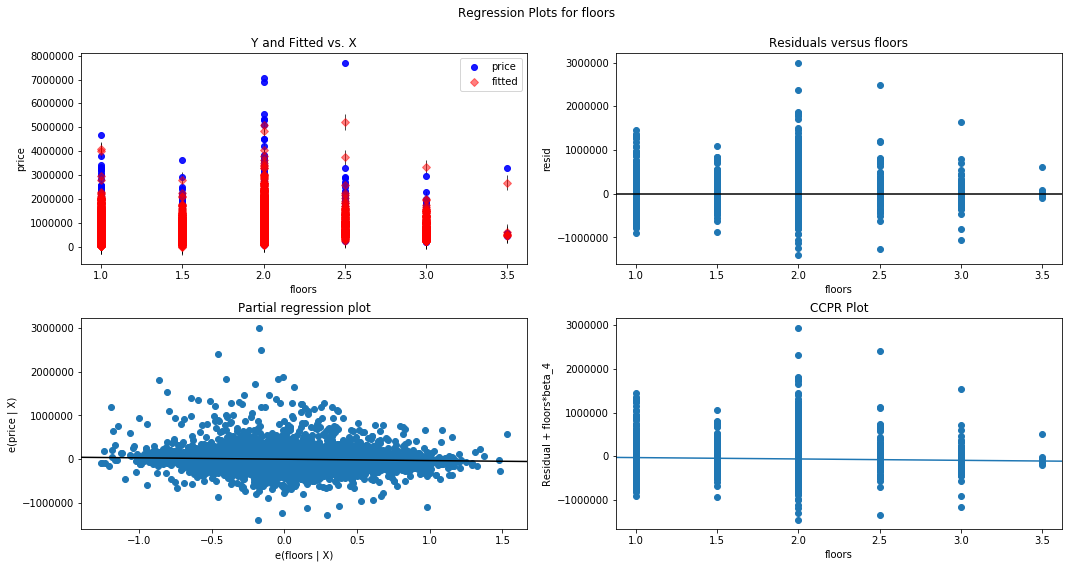

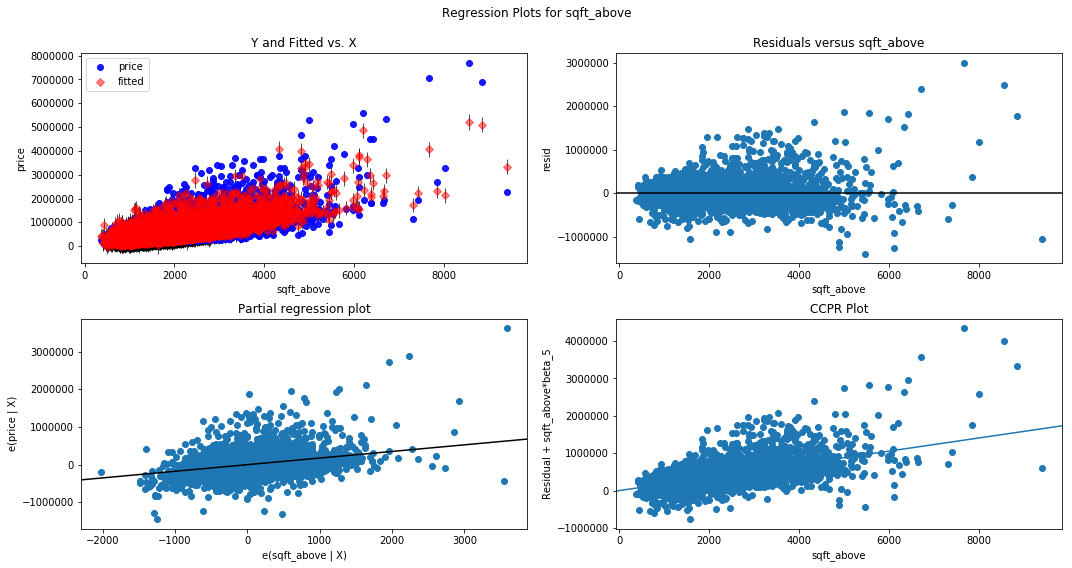

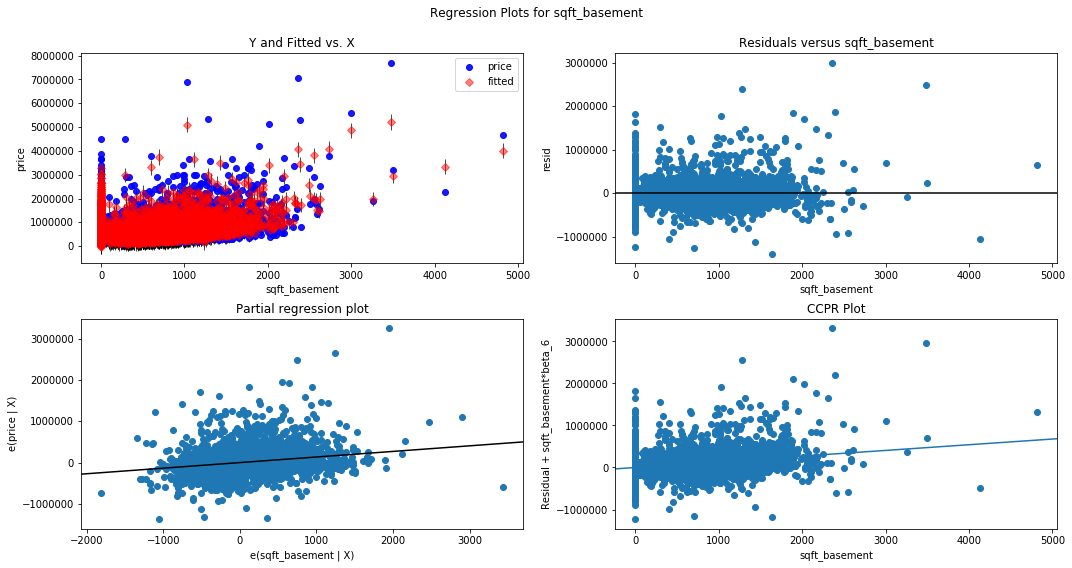

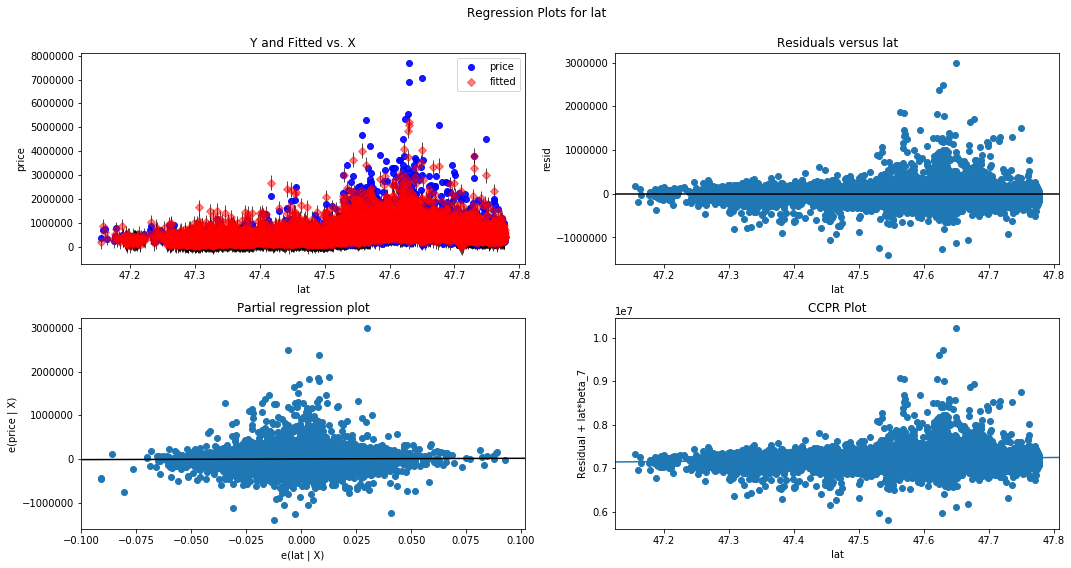

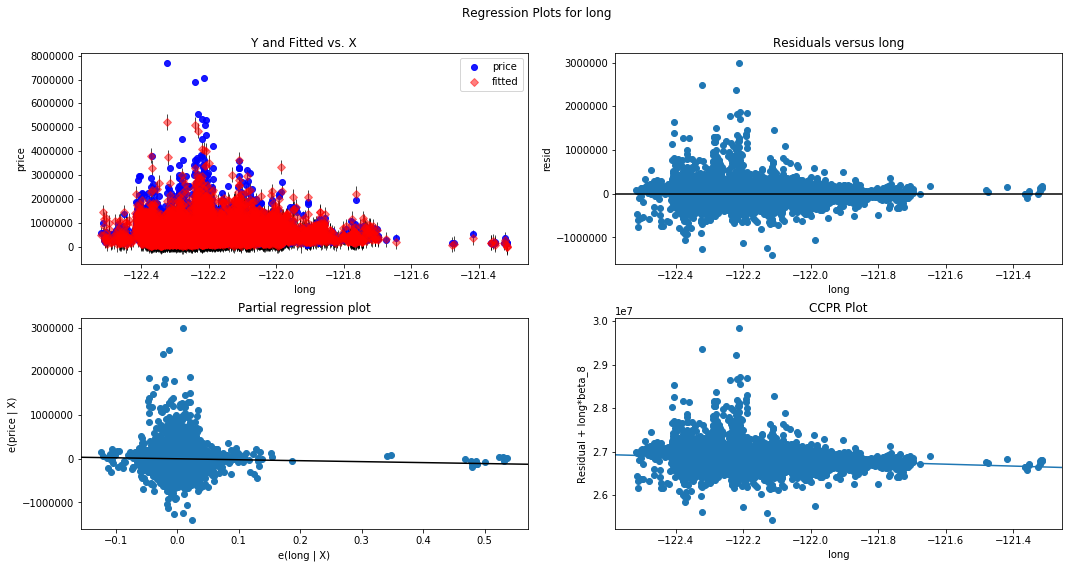

In [18]:
for col in ['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'lat', 'long']:
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()

### Take 2

- **Quantitative features:** bedrooms, bathrooms, sqft_lot, floors, sqft_above, sqft_basement, lat, long
- **Categorical features:** waterfront, condition, grade, yr_renovated, yt_built, zipcode
- **Notes:** log normalization: `price`, `sqft_above`, `sqft_basement`, `sqft_lot`
- **Observations:** $R^2$ increased, I'll keep normalizing the features and target
- **Results:**
  - $R^2 adj$: 0.879
  - MSE (train): 0.032953350286068564
  - MSE (test): 0.03502116419851066

In [151]:
X_train = X_train.drop(['waterfront_0', 'condition_1', 'grade_3', 'yr_renovated_1944', 'yr_built_1900', 'zipcode_98002'],
                       axis=1)
X_test = X_test.drop(['waterfront_0', 'condition_1', 'grade_3', 'yr_renovated_1944', 'yr_built_1900', 'zipcode_98002'],
                       axis=1)

In [152]:
predictors = sm.add_constant(X_train)
model = sm.OLS(y_train, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     456.3
Date:                Sun, 16 Jun 2019   Prob (F-statistic):               0.00
Time:                        10:49:50   Log-Likelihood:                 4965.0
No. Observations:               17276   AIC:                            -9376.
Df Residuals:                   16999   BIC:                            -7227.
Df Model:                         276                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -88.8603      7.909    -11.235      0.000    -104.363     -73.358
bedrooms             -0.0096      0.002     -4.450      0.000      -0.014      -0.005
bathrooms             0.0382      0.003     11.012      0.000       0.031       0.045
sqft_lot              0.0813      0.003     32.331      0.000       0.076       0.086
floors               -0.0528      0.005    -11.704      0.000      -0.062      -0.044
sqft_above            0.4518      0.008     58.006      0.000       0.437       0.467
sqft_basement         0.0227      0.001     36.556      0.000       0.021       0.024
lat                   0.5392      0.081      6.624      0.000       0.380       0.699
long                 -0.5885      0.059    -10.059      0.000      -0.703      -0.474
waterfront_1          0.6663      0.018     37.415      0.000       0.631       0.701
condition_2           0.0847      0.041      2.092      0.036       0.005       0.164
condition_3           0.2287      0.038      6.080      0.000       0.155       0.302
condition_4           0.2850      0.038      7.570      0.000       0.211       0.359
condition_5           0.3470      0.038      9.158      0.000       0.273       0.421
grade_10             -0.0267      0.185     -0.144      0.886      -0.390       0.336
grade_11              0.1064      0.186      0.573      0.566      -0.257       0.470
grade_12              0.2394      0.187      1.282      0.200      -0.127       0.605
grade_13              0.5087      0.193      2.633      0.008       0.130       0.887
grade_4              -0.4852      0.189     -2.562      0.010      -0.856      -0.114
grade_5              -0.5555      0.185     -2.999      0.003      -0.919      -0.192
grade_6              -0.4811      0.185     -2.603      0.009      -0.843      -0.119
grade_7              -0.3760      0.185     -2.034      0.042      -0.738      -0.014
grade_8              -0.2713      0.185     -1.467      0.142      -0.634       0.091
grade_9              -0.1348      0.185     -0.728      0.467      -0.498       0.228
yr_built_1901        -0.0936      0.042     -2.248      0.025      -0.175      -0.012
yr_built_1902        -0.0753      0.046     -1.632      0.103      -0.166       0.015
yr_built_1903        -0.0657      0.037     -1.758      0.079      -0.139       0.008
yr_built_1904         0.0091      0.038      0.242      0.809      -0.065       0.083
yr_built_1905         0.0173      0.032      0.538      0.590      -0.046       0.080
yr_built_1906        -0.0056      0.030     -0.184      0.854      -0.065       0.054
yr_built_1907         0.0172      0.034      0.503      0.615      -0.050       0.084
yr_built_1908        -0.0666      0.032     -2.064      0.039      -0.130      -0.003
yr_built_1909         0.0207      0.031      0.669      0.503      -0.040

In [153]:
predictors_test = sm.add_constant(X_test)
y_hat_train = model.predict(predictors)
y_hat_test = model.predict(predictors_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.032953350286068564
Test Mean Squarred Error: 0.03502116419851066


C:\Data\Python37\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


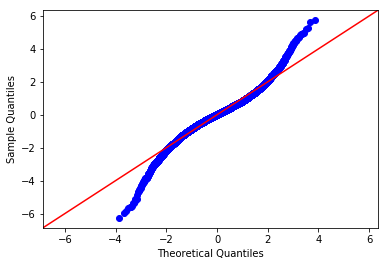

In [154]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

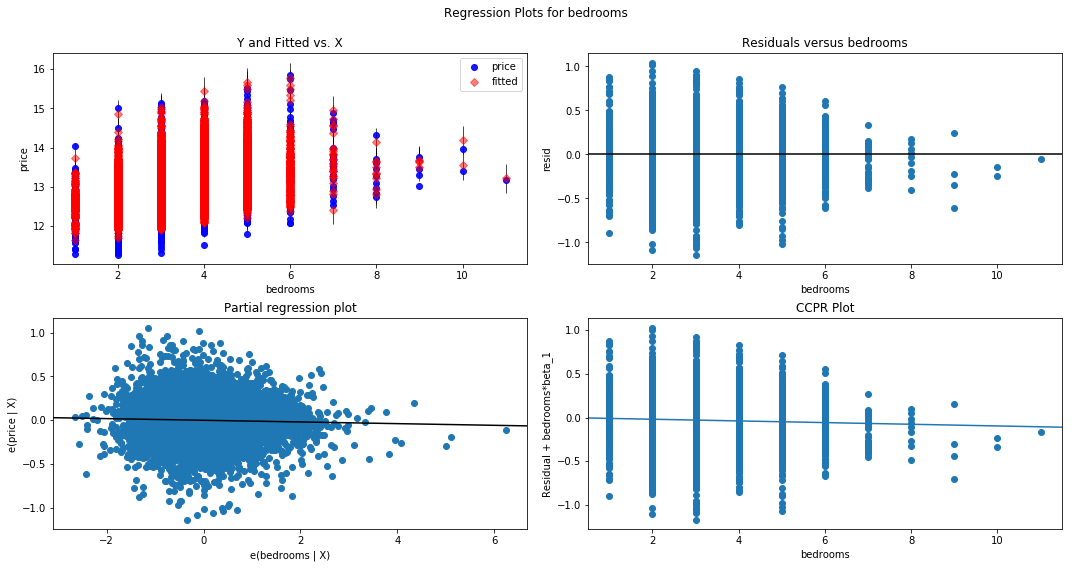

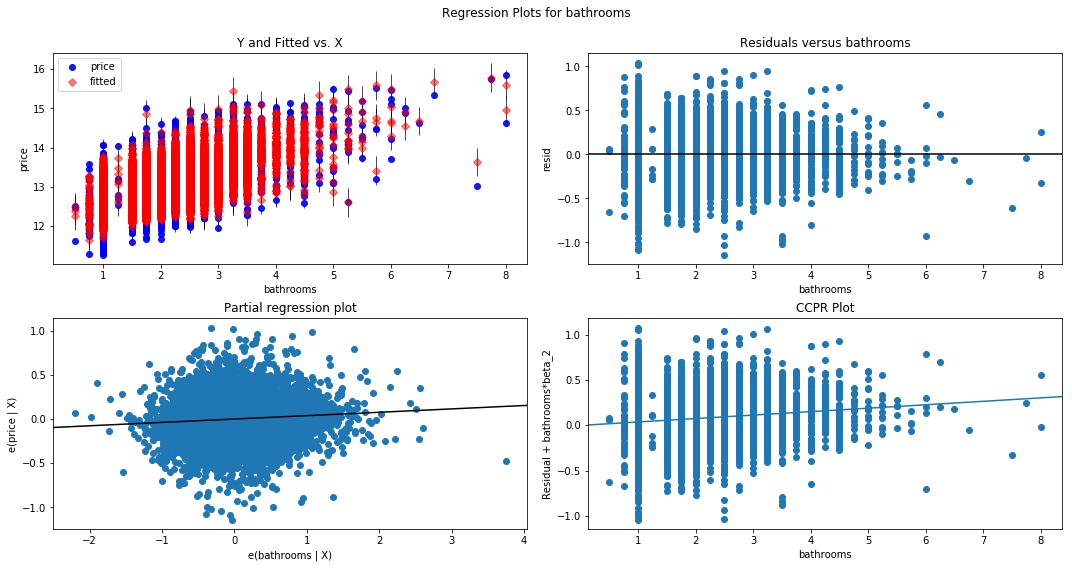

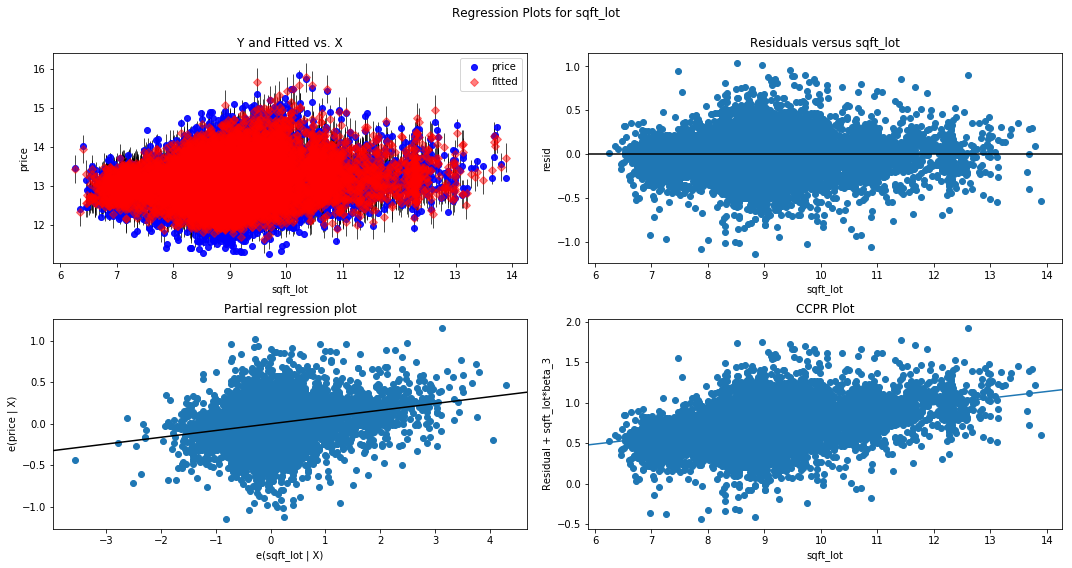

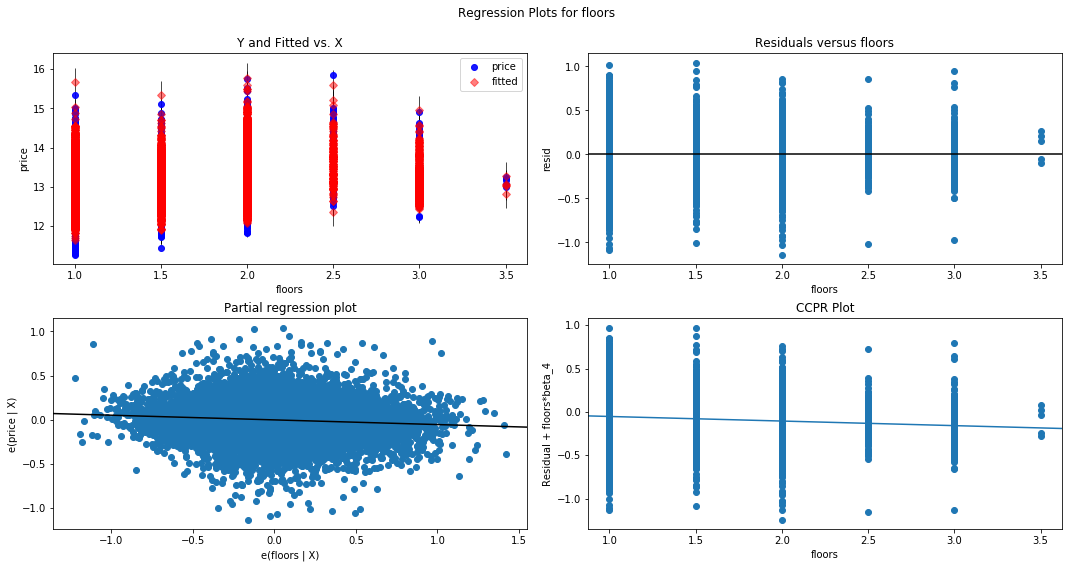

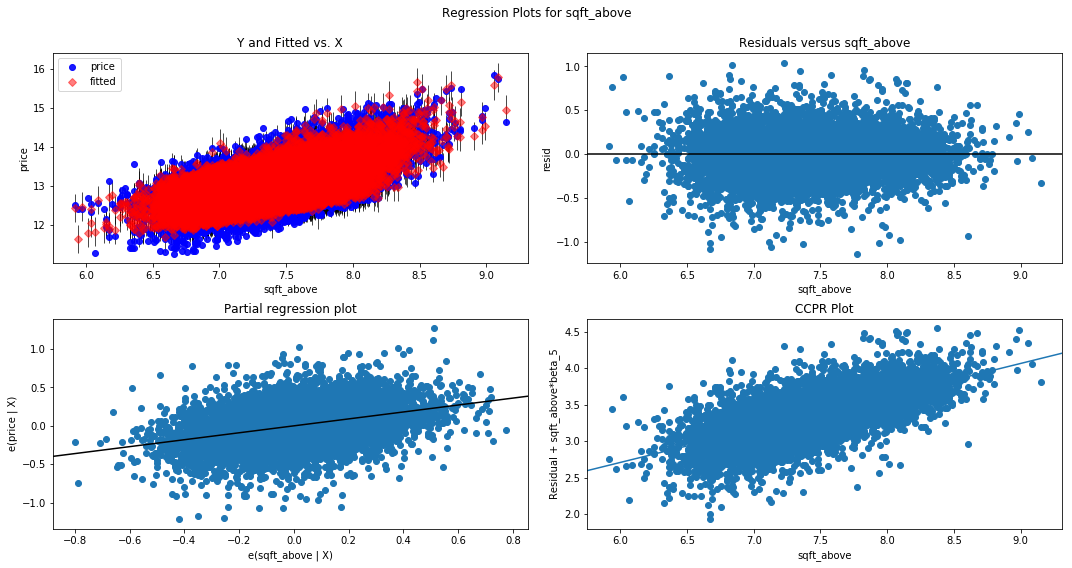

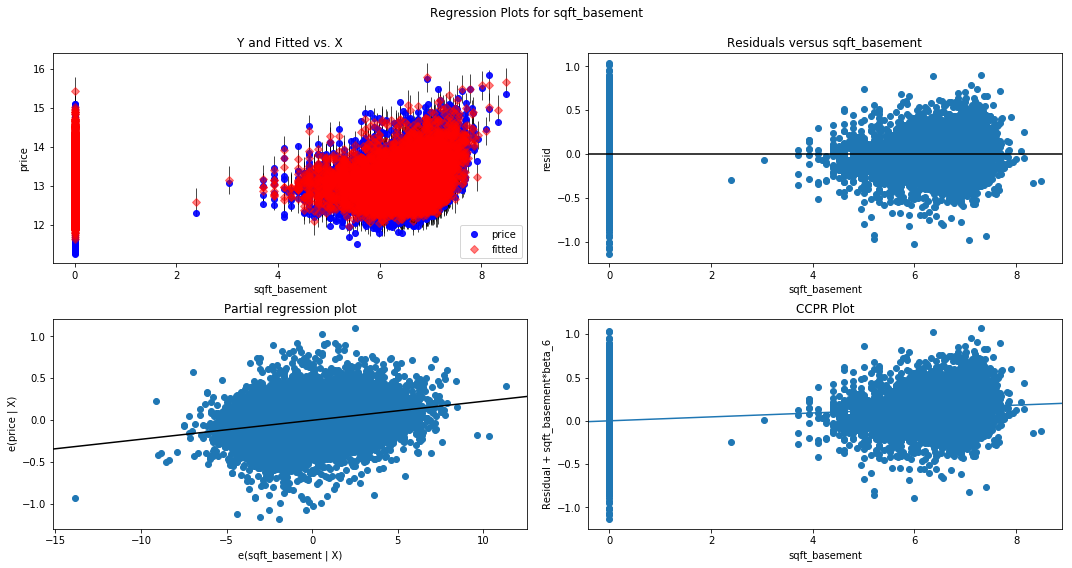

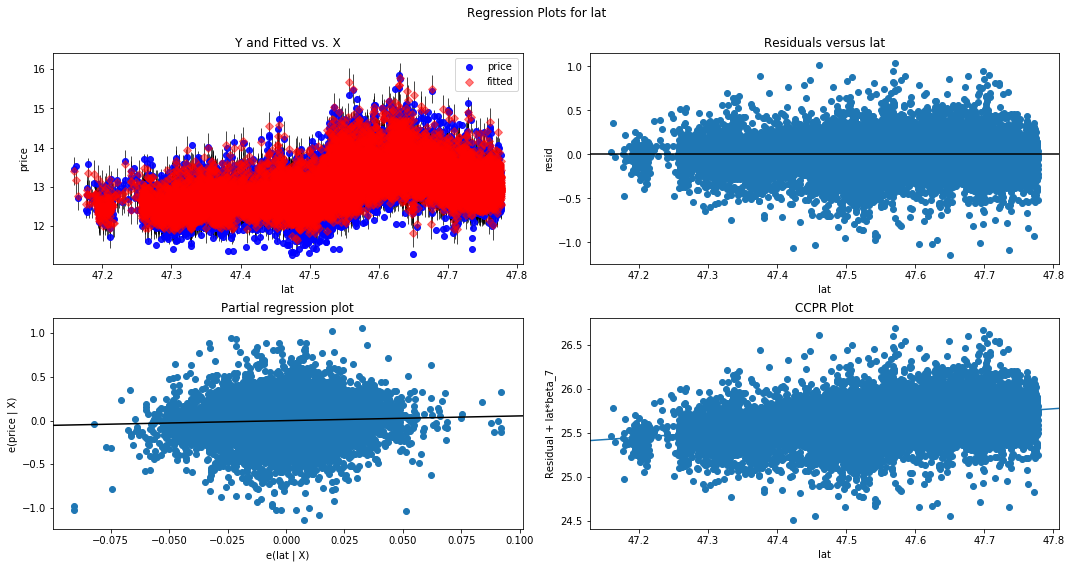

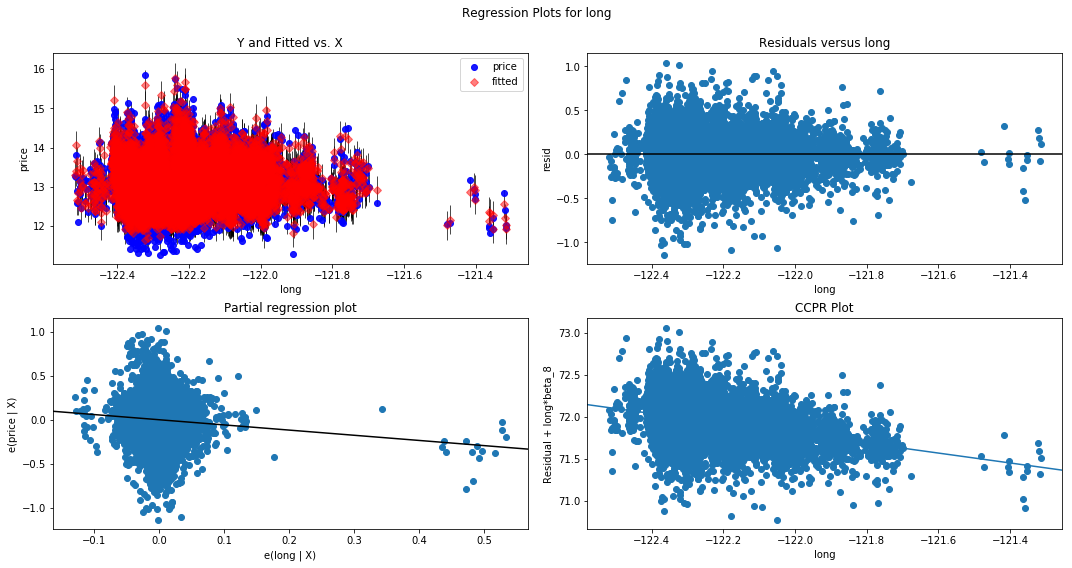

In [155]:
for col in ['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'lat', 'long']:
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()

### Take 3 - Best model

- **Quantitative features:** ~~bedrooms~~, bathrooms, sqft_lot, floors, sqft_above, sqft_basement, lat, long
- **Categorical features:** waterfront, condition, grade, yr_renovated, yt_built, zipcode
- **Notes:** log normalization: `price`, `sqft_above`, `sqft_basement`, `sqft_lot`
- **Observations:** $R^2$ increased, I'll remove bedrooms from the predictors
- **Results:**
  - $R^2 adj$: 0.880
  - MSE (train): 0.03286597878260463
  - MSE (test): 0.037946160979032584

In [14]:
X_train = X_train.drop(['bedrooms', 'waterfront_0', 'condition_1', 'grade_3', 'yr_renovated_1944', 'yr_built_1900', 'zipcode_98002'],
                       axis=1)
X_test = X_test.drop(['bedrooms', 'waterfront_0', 'condition_1', 'grade_3', 'yr_renovated_1944', 'yr_built_1900', 'zipcode_98002'],
                       axis=1)

In [15]:
predictors = sm.add_constant(X_train)
model = sm.OLS(y_train, predictors).fit()
model.summary()

C:\Data\Python37\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     469.1
Date:                Sun, 16 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:05:51   Log-Likelihood:                 4987.9
No. Observations:               17276   AIC:                            -9434.
Df Residuals:                   17005   BIC:                            -7332.
Df Model:                         270                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -75.0817      7.670     -9.789      0.000     -90.116     -60.048
bathrooms             0.0353      0.003     10.517      0.000       0.029       0.042
sqft_lot              0.0818      0.003     32.339      0.000       0.077       0.087
floors               -0.0505      0.005    -11.168      0.000      -0.059      -0.042
sqft_above            0.4419      0.007     60.637      0.000       0.428       0.456
sqft_basement         0.0227      0.001     37.671      0.000       0.021       0.024
lat                   0.5223      0.081      6.444      0.000       0.363       0.681
long                 -0.4916      0.057     -8.607      0.000      -0.604      -0.380
waterfront_1          0.6745      0.018     37.565      0.000       0.639       0.710
condition_2           0.1755      0.043      4.121      0.000       0.092       0.259
condition_3           0.2938      0.040      7.402      0.000       0.216       0.372
condition_4           0.3500      0.040      8.816      0.000       0.272       0.428
condition_5           0.4147      0.040     10.388      0.000       0.336       0.493
grade_10             -0.0166      0.185     -0.090      0.928      -0.379       0.346
grade_11              0.1077      0.185      0.581      0.561      -0.255       0.471
grade_12              0.2628      0.186      1.410      0.158      -0.102       0.628
grade_13              0.4910      0.194      2.537      0.011       0.112       0.870
grade_4              -0.4372      0.189     -2.310      0.021      -0.808      -0.066
grade_5              -0.5635      0.185     -3.048      0.002      -0.926      -0.201
grade_6              -0.4644      0.185     -2.517      0.012      -0.826      -0.103
grade_7              -0.3615      0.185     -1.959      0.050      -0.723       0.000
grade_8              -0.2552      0.185     -1.382      0.167      -0.617       0.107
grade_9              -0.1201      0.185     -0.650      0.516      -0.482       0.242
yr_built_1901        -0.1425      0.044     -3.265      0.001      -0.228      -0.057
yr_built_1902        -0.0788      0.045     -1.770      0.077      -0.166       0.008
yr_built_1903        -0.0871      0.036     -2.399      0.016      -0.158      -0.016
yr_built_1904         0.0025      0.039      0.063      0.949      -0.074       0.079
yr_built_1905        -0.0180      0.032     -0.554      0.580      -0.082       0.046
yr_built_1906        -0.0158      0.031     -0.500      0.617      -0.077       0.046
yr_built_1907        -0.0165      0.033     -0.493      0.622      -0.082       0.049
yr_built_1908        -0.0542      0.032     -1.688      0.091      -0.117       0.009
yr_built_1909        -0.0160      0.032     -0.507      0.612      -0.078       0.046
yr_built_1910        -0.0167      0.029     -0.583      0.560      -0.073

In [16]:
predictors_test = sm.add_constant(X_test)
y_hat_train = model.predict(predictors)
y_hat_test = model.predict(predictors_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.03286597878260463
Test Mean Squarred Error: 0.037946160979032584


C:\Data\Python37\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


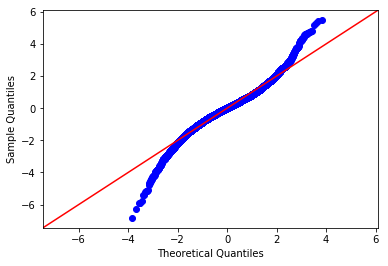

In [17]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

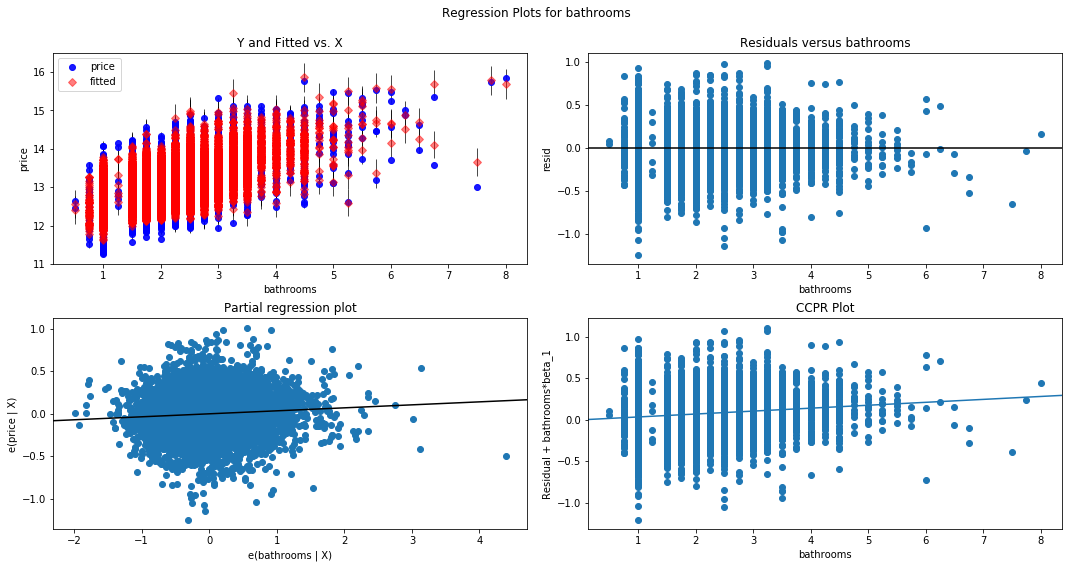

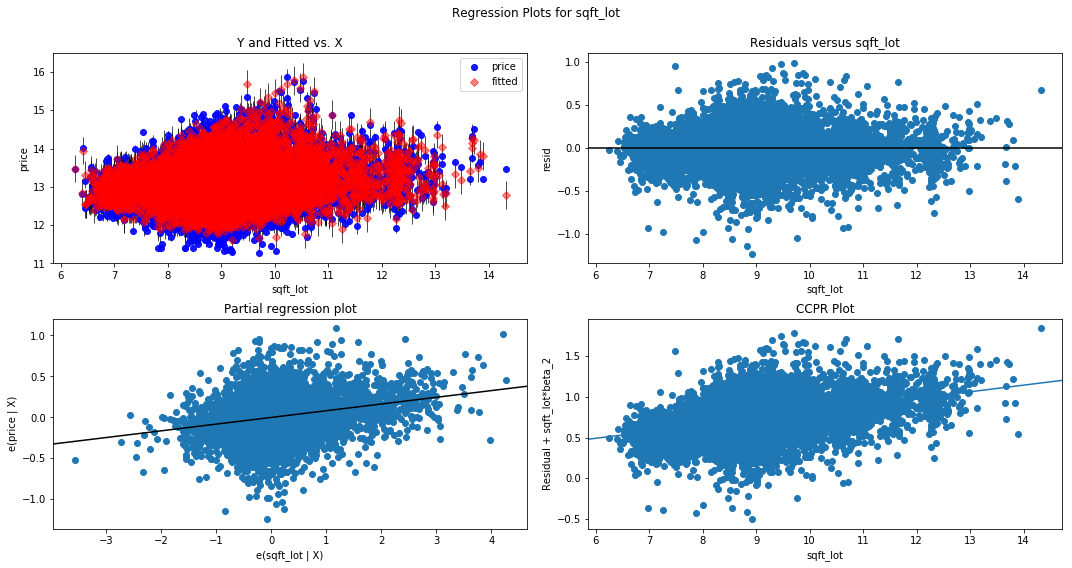

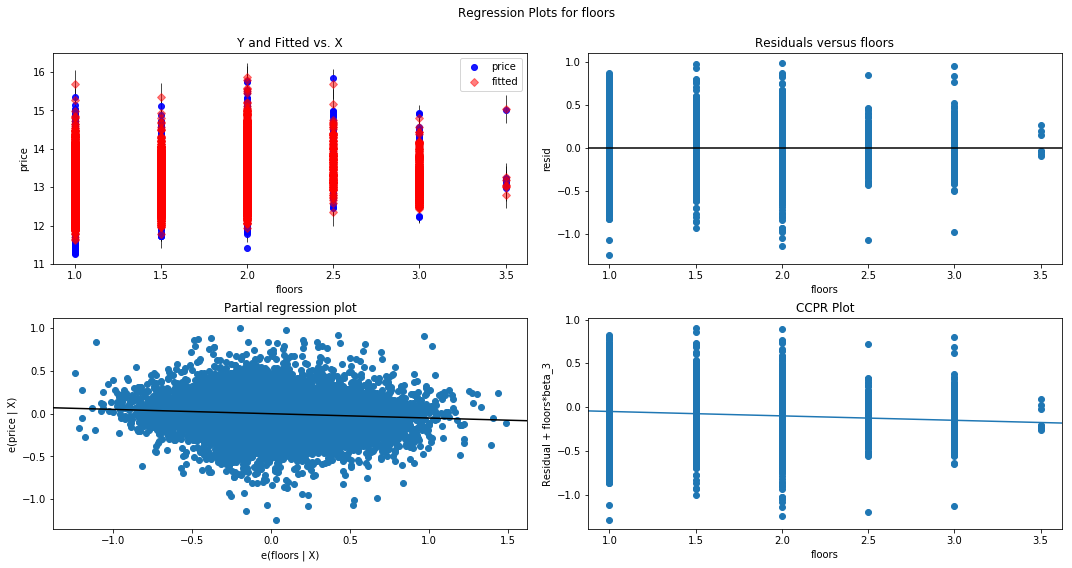

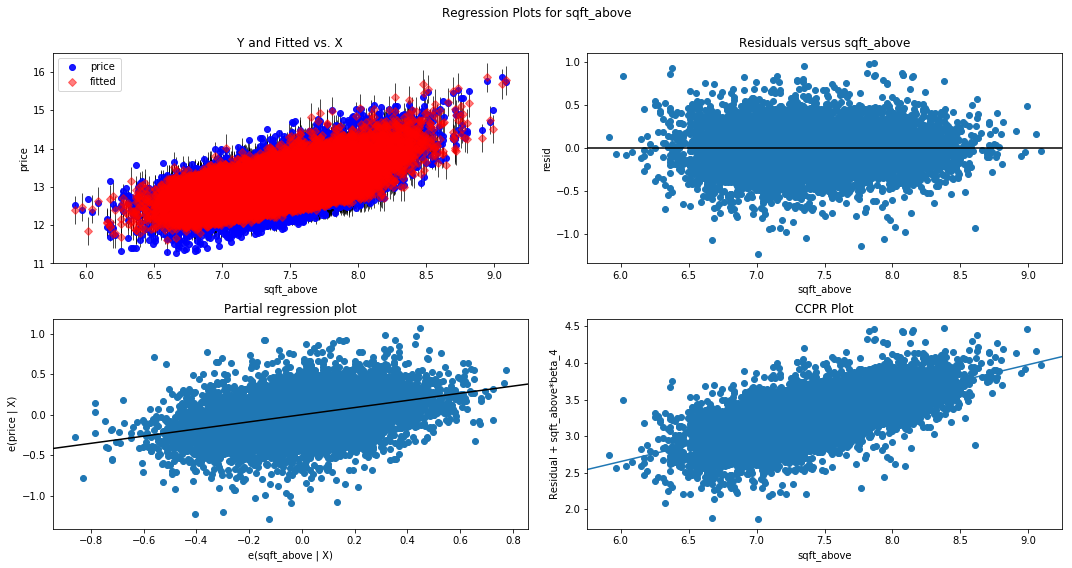

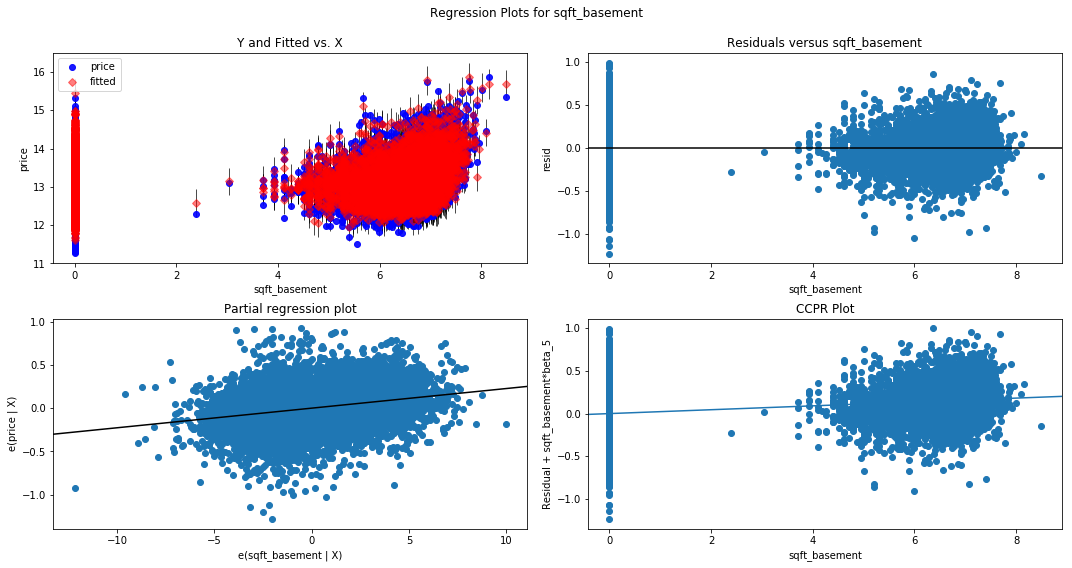

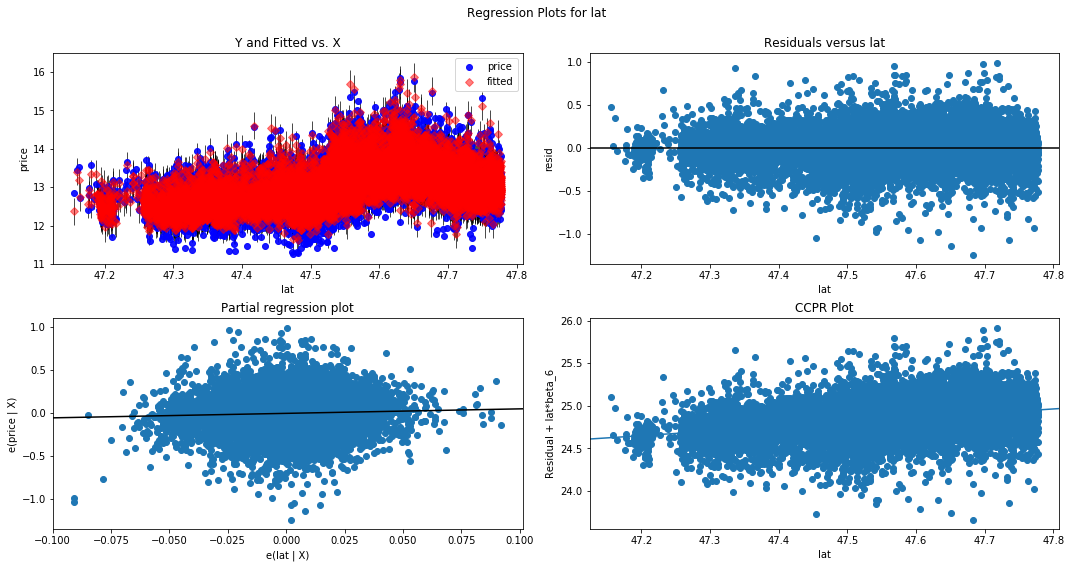

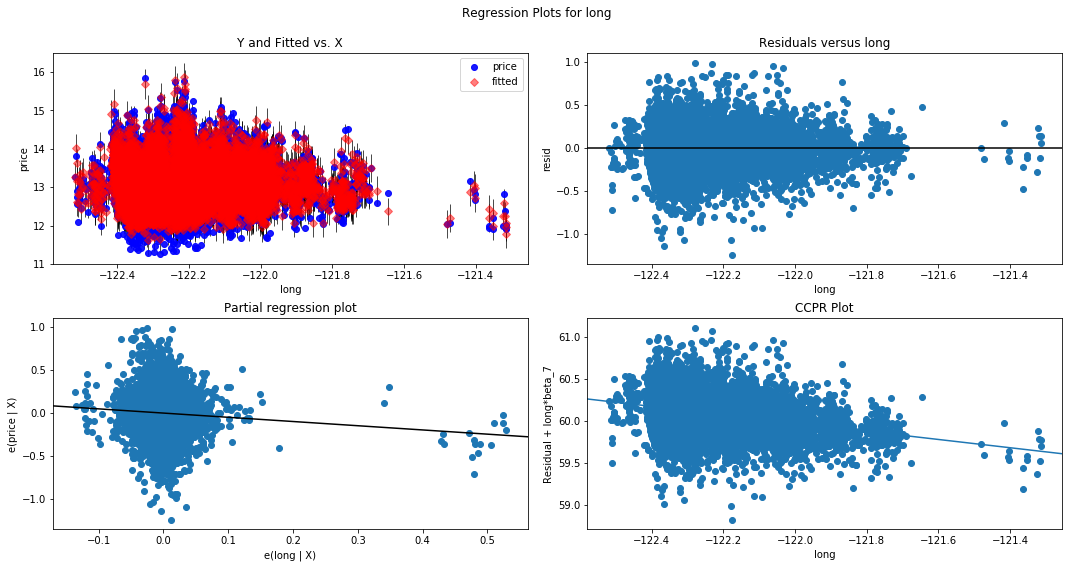

In [18]:
for col in ['bathrooms', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'lat', 'long']:
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()

### Take 4

- **Quantitative features:** ~~bedrooms~~, condition, bathrooms, sqft_lot, floors, sqft_above, sqft_basement, lat, long
- **Categorical features:** waterfront, ~~condition~~, grade, yr_renovated, yt_built, zipcode
- **Notes:** making condition quantitative
- **Observations:** no changes, I'll keep it as categorical
- **Results:**
  - $R^2 adj$: 0.878
  - MSE (train): 0.033244847757894255
  - MSE (test): 0.034206033260167336

In [32]:
X_train = X_train.drop(['bedrooms', 'waterfront_0', 'grade_3', 'yr_renovated_1944', 'yr_built_1900', 'zipcode_98002'],
                       axis=1)
X_test = X_test.drop(['bedrooms', 'waterfront_0', 'grade_3', 'yr_renovated_1944', 'yr_built_1900', 'zipcode_98002'],
                       axis=1)

In [33]:
predictors = sm.add_constant(X_train)
model = sm.OLS(y_train, predictors).fit()
model.summary()

C:\Data\Python37\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     463.3
Date:                Sun, 16 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:07:31   Log-Likelihood:                 4888.9
No. Observations:               17276   AIC:                            -9236.
Df Residuals:                   17005   BIC:                            -7134.
Df Model:                         270                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -82.7954      8.040    -10.298      0.000     -98.555     -67.036
bathrooms             0.0368      0.003     10.965      0.000       0.030       0.043
sqft_lot              0.0820      0.003     32.431      0.000       0.077       0.087
floors               -0.0461      0.005    -10.219      0.000      -0.055      -0.037
condition             0.0632      0.003     25.087      0.000       0.058       0.068
sqft_above            0.4372      0.007     59.849      0.000       0.423       0.452
sqft_basement         0.0223      0.001     36.861      0.000       0.021       0.023
lat                   0.5328      0.081      6.556      0.000       0.374       0.692
long                 -0.5420      0.060     -9.033      0.000      -0.660      -0.424
waterfront_1          0.6897      0.018     38.297      0.000       0.654       0.725
grade_10             -0.0019      0.186     -0.010      0.992      -0.366       0.363
grade_11              0.1360      0.186      0.730      0.465      -0.229       0.501
grade_12              0.2627      0.187      1.402      0.161      -0.105       0.630
grade_13              0.5911      0.196      3.009      0.003       0.206       0.976
grade_4              -0.4660      0.190     -2.453      0.014      -0.838      -0.094
grade_5              -0.5632      0.186     -3.029      0.002      -0.928      -0.199
grade_6              -0.4602      0.186     -2.480      0.013      -0.824      -0.096
grade_7              -0.3535      0.186     -1.904      0.057      -0.717       0.010
grade_8              -0.2438      0.186     -1.313      0.189      -0.608       0.120
grade_9              -0.1103      0.186     -0.593      0.553      -0.474       0.254
yr_built_1901        -0.1094      0.043     -2.522      0.012      -0.194      -0.024
yr_built_1902        -0.0479      0.045     -1.067      0.286      -0.136       0.040
yr_built_1903        -0.1071      0.039     -2.720      0.007      -0.184      -0.030
yr_built_1904        -0.0055      0.039     -0.139      0.890      -0.083       0.072
yr_built_1905         0.0030      0.033      0.090      0.928      -0.062       0.067
yr_built_1906        -0.0149      0.032     -0.471      0.637      -0.077       0.047
yr_built_1907         0.0095      0.034      0.276      0.783      -0.058       0.077
yr_built_1908        -0.0682      0.032     -2.164      0.030      -0.130      -0.006
yr_built_1909        -0.0005      0.031     -0.015      0.988      -0.061       0.061
yr_built_1910         0.0094      0.029      0.325      0.745      -0.048       0.066
yr_built_1911         0.0089      0.033      0.268      0.789      -0.056       0.074
yr_built_1912        -0.0119      0.032     -0.369      0.712      -0.075       0.051
yr_built_1913        -0.0042      0.036     -0.115      0.909      -0.075

In [34]:
predictors_test = sm.add_constant(X_test)
y_hat_train = model.predict(predictors)
y_hat_test = model.predict(predictors_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.033244847757894255
Test Mean Squarred Error: 0.034206033260167336


C:\Data\Python37\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


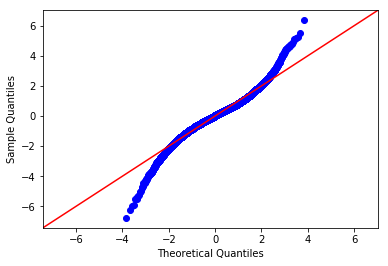

In [35]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

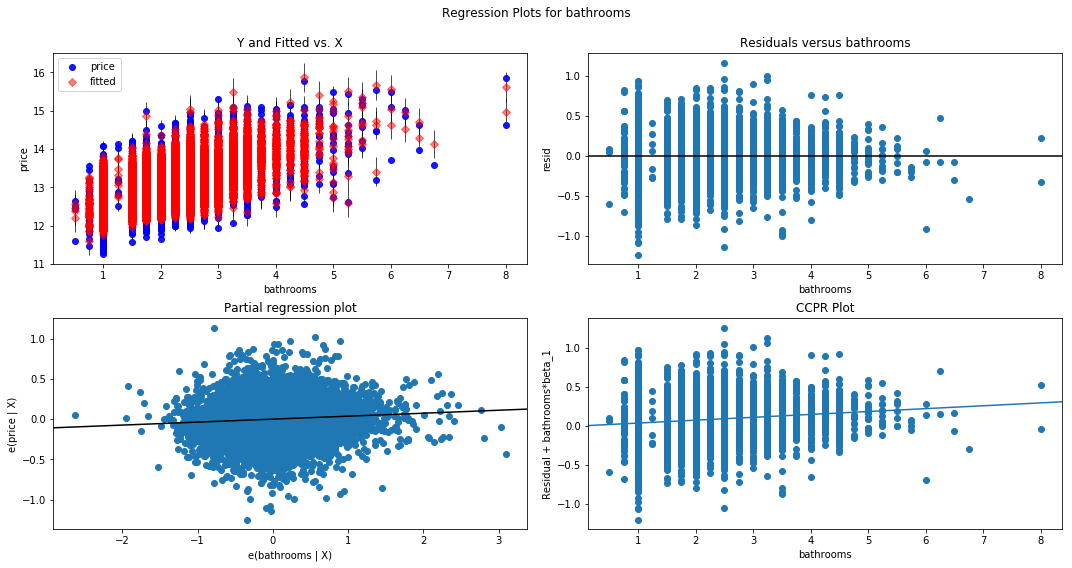

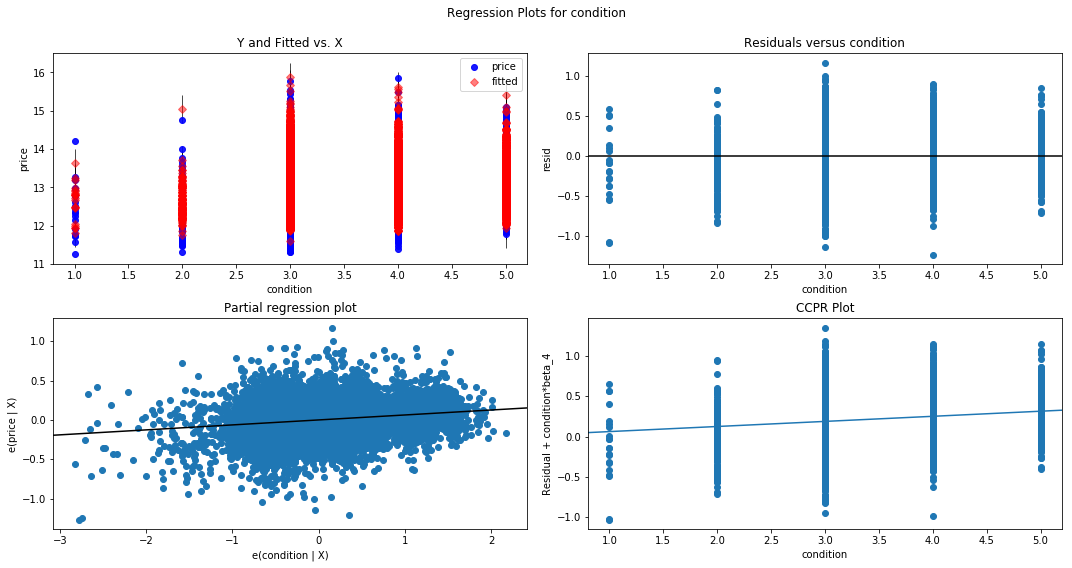

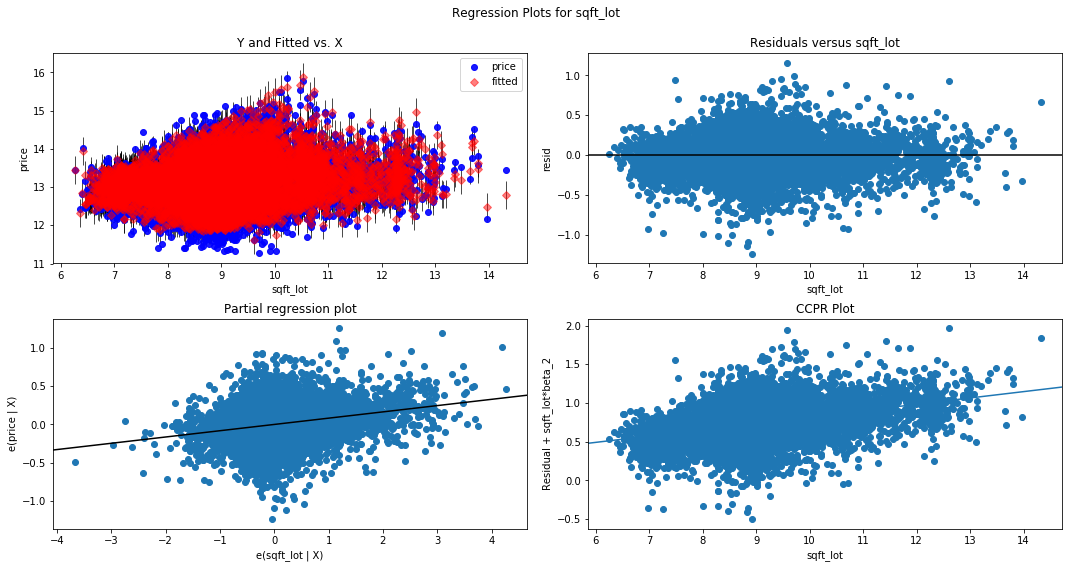

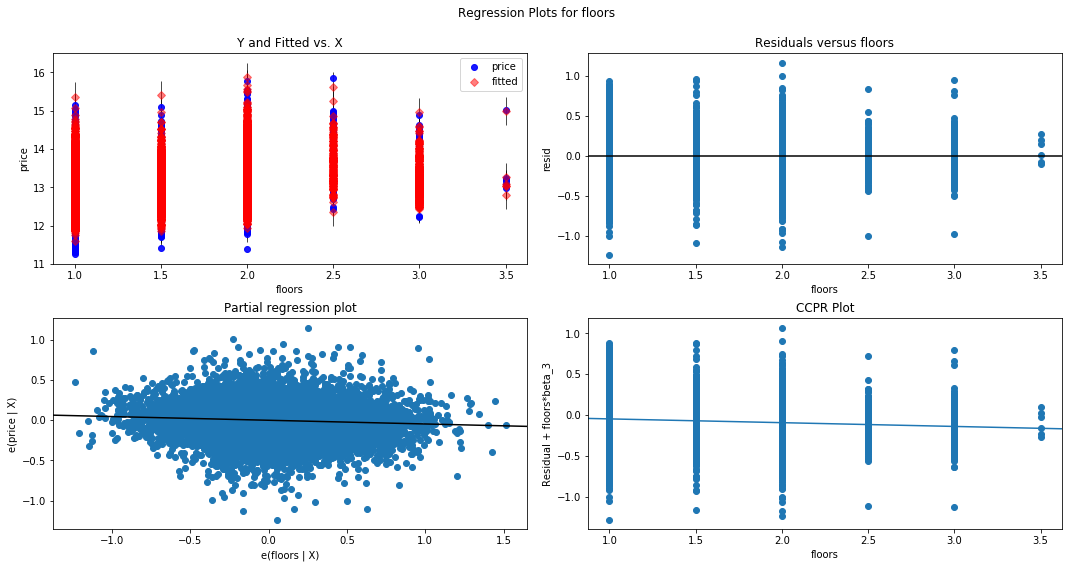

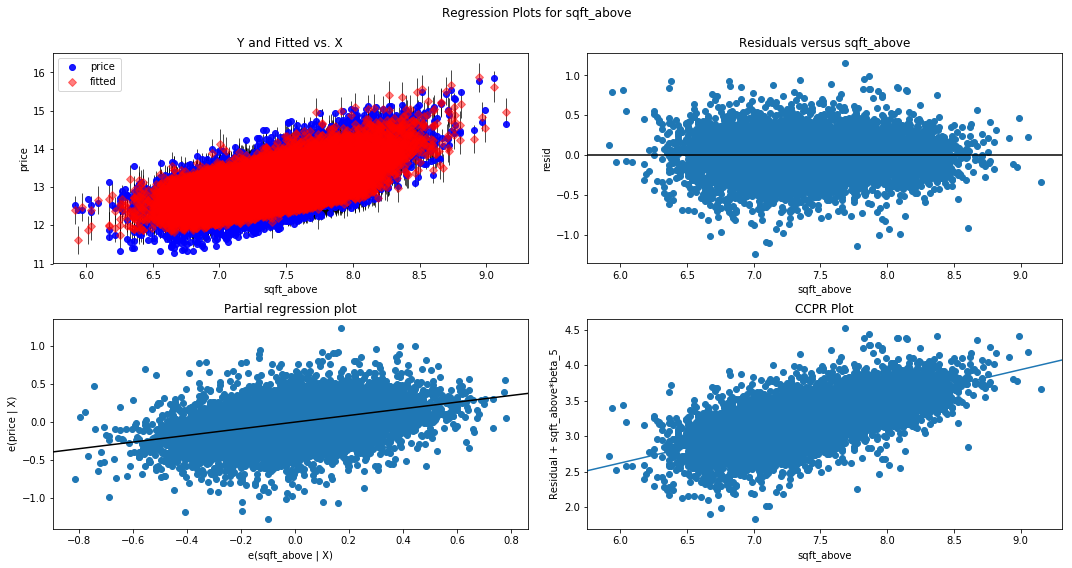

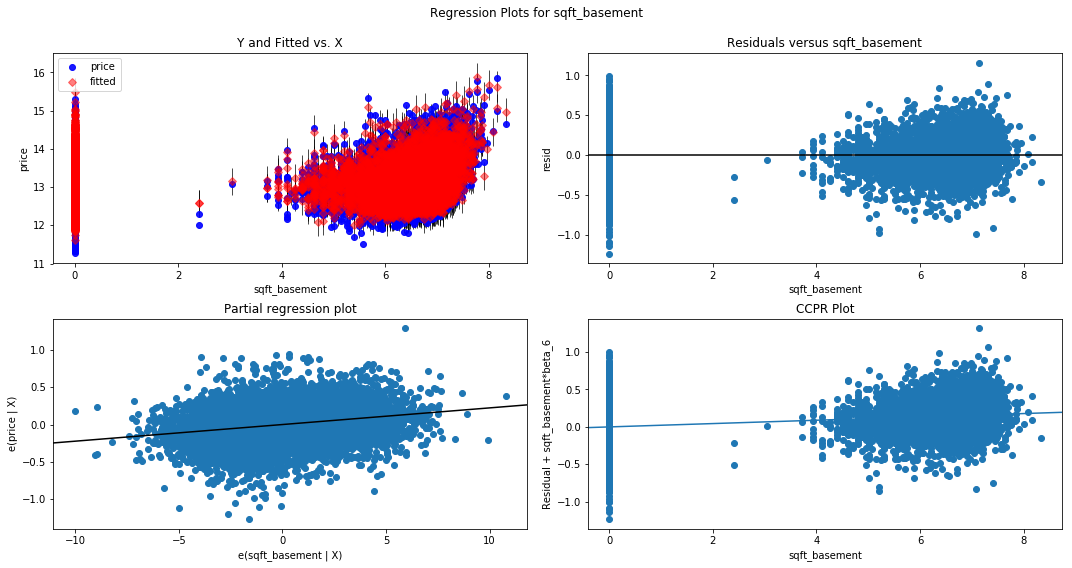

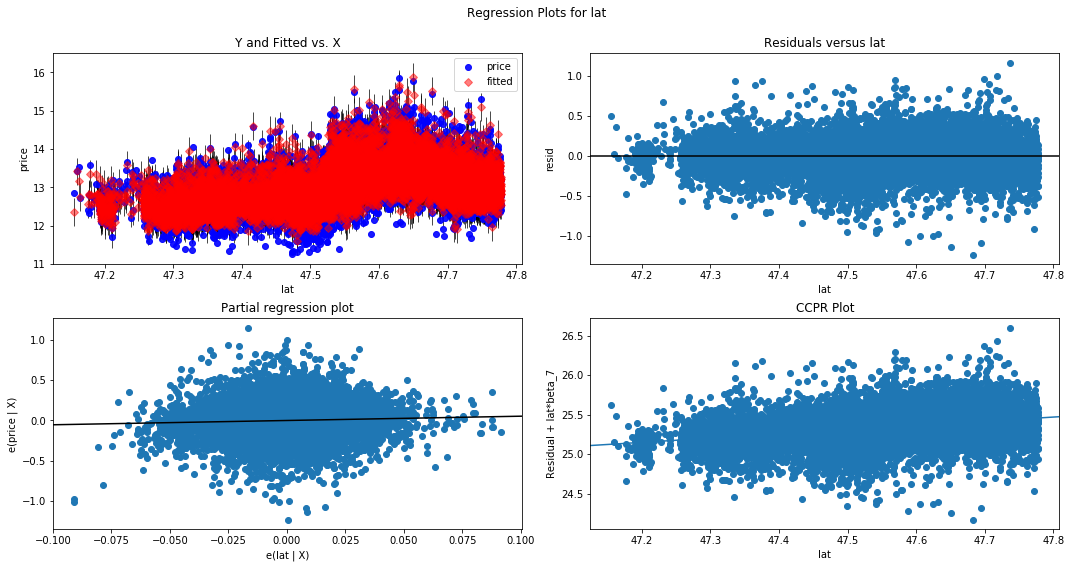

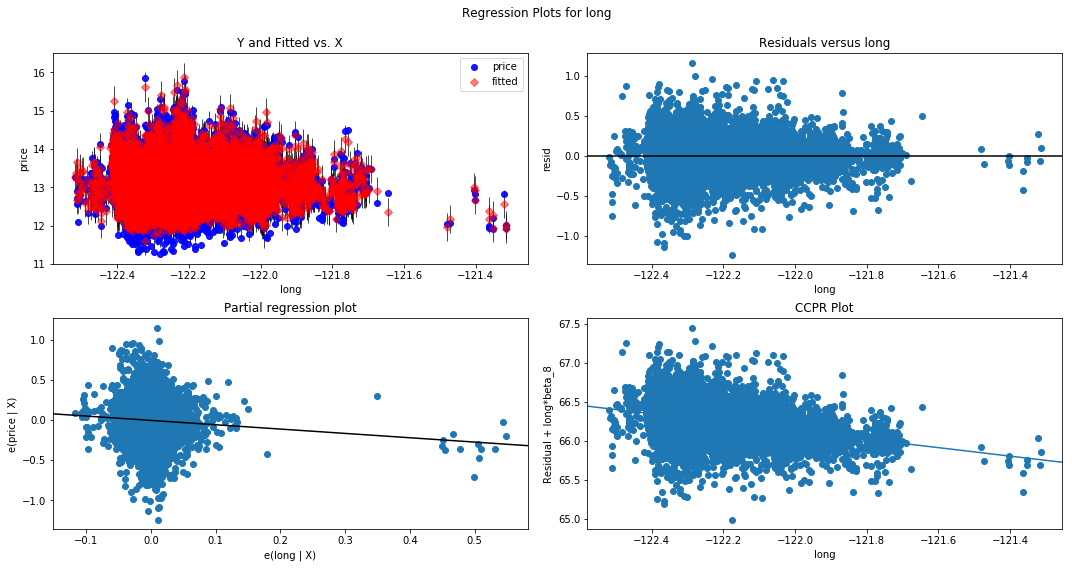

In [36]:
for col in ['bathrooms', 'condition', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'lat', 'long']:
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()

### Take 5

#### Stepwise selection

In [840]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [705]:
result = stepwise_selection(X_train, y_train, verbose=True)
print('resulting features:')
print(result)

C:\Data\Python37\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Data\Python37\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Data\Python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Data\Python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Data\Python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Add  grade_9                        with p-value 0.0
Add  lat                            with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  sqft_basement                  with p-value 0.0
Add  zipcode_98004                  with p-value 8.83564e-222
Add  waterfront_1                   with p-value 6.91806e-198
Add  waterfront_0                   with p-value 0.0
Add  grade_10                       with p-value 7.54512e-158
Add  grade_11                       with p-value 1.16324e-155
Add  zipcode_98040                  with p-value 7.72507e-126
Add  grade_8                        with p-value 1.05986e-120
Add  grade_12                       with p-value 1.80165e-127
Add  zipcode_98155                  with p-value 1.79092e-113
Add  condition_3                    with p-value 1.10725e-113
Add  zipcode_98133                  with p-value 1.57132e-110
Add  zipcode_98112                  with p-value 1.29313e-105
Add  zipcode_98028                  with p-value 5.96

C:\Data\Python37\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


Drop zipcode_98038                  with p-value 0.121053
Add  zipcode_98092                  with p-value 1.89972e-09
Add  zipcode_98033                  with p-value 6.75483e-11
Add  zipcode_98075                  with p-value 2.01024e-09
Drop zipcode_98074                  with p-value 0.675156
Add  zipcode_98007                  with p-value 2.33418e-09
Drop zipcode_98052                  with p-value 0.926605
Add  zipcode_98038                  with p-value 2.64451e-07
Drop zipcode_98022                  with p-value 0.725254
Add  zipcode_98166                  with p-value 3.57312e-11
Drop zipcode_98010                  with p-value 0.439533
Add  zipcode_98070                  with p-value 6.30569e-13
Add  zipcode_98022                  with p-value 6.73186e-06
Drop zipcode_98053                  with p-value 0.266957
Add  zipcode_98118                  with p-value 1.94776e-07
Add  zipcode_98010                  with p-value 2.77604e-08
Drop zipcode_98027                  with p

#### Model

- **Quantitative features:** ~~bedrooms~~, bathrooms, sqft_lot, floors, sqft_above, sqft_basement, lat, long
- **Categorical features:** waterfront, condition, grade, yr_renovated, yt_built, zipcode
- **Notes:** using variables from stepwise selection
- **Observations:** $R^2$ decreased, I wont use the stepwise selection
- **Results:**
  - $R^2 adj$: 0.873
  - MSE (train): 0.03518560373441905
  - MSE (test): 0.03422641190674535

In [82]:
X_train = X_train.drop(['bedrooms', 'waterfront_0', 'condition_1', 'grade_3', 'yr_renovated_1944', 'yr_built_1900', 'zipcode_98002'],
                       axis=1)
X_test = X_test.drop(['bedrooms', 'waterfront_0', 'condition_1', 'grade_3', 'yr_renovated_1944', 'yr_built_1900', 'zipcode_98002'],
                       axis=1)

In [83]:
stepwise_vars = ['grade_9', 'lat', 'sqft_above', 'sqft_basement', 'zipcode_98004', 'waterfront_1', 'waterfront_0', 'grade_10', 'grade_11', 'zipcode_98040', 'grade_8', 'grade_12', 'zipcode_98155', 'condition_3', 'zipcode_98133', 'zipcode_98112', 'zipcode_98028', 'zipcode_98019', 'zipcode_98039', 'zipcode_98072', 'zipcode_98011', 'zipcode_98034', 'zipcode_98077', 'zipcode_98168', 'zipcode_98125', 'zipcode_98014', 'zipcode_98177', 'sqft_lot', 'grade_7', 'grade_13', 'zipcode_98116', 'zipcode_98119', 'zipcode_98178', 'condition_5', 'condition_4', 'zipcode_98055', 'zipcode_98109', 'zipcode_98122', 'zipcode_98006', 'zipcode_98199', 'zipcode_98105', 'zipcode_98102', 'zipcode_98144', 'zipcode_98058', 'yr_renovated_nan', 'zipcode_98188', 'zipcode_98106', 'bathrooms', 'zipcode_98056', 'zipcode_98031', 'zipcode_98146', 'zipcode_98032', 'zipcode_98108', 'yr_built_2014', 'long', 'zipcode_98029', 'yr_built_2013', 'zipcode_98198', 'floors', 'zipcode_98030', 'zipcode_98023', 'zipcode_98107', 'zipcode_98103', 'zipcode_98042', 'yr_built_2012', 'zipcode_98059', 'zipcode_98148', 'yr_built_1926', 'bedrooms', 'yr_built_1978', 'yr_built_1979', 'yr_built_1966', 'zipcode_98126', 'yr_built_2011', 'zipcode_98005', 'zipcode_98115', 'yr_built_1959', 'grade_5', 'zipcode_98117', 'zipcode_98008', 'zipcode_98001', 'zipcode_98002', 'zipcode_98003', 'zipcode_98092', 'zipcode_98033', 'zipcode_98075', 'zipcode_98007', 'zipcode_98038', 'zipcode_98166', 'zipcode_98070', 'zipcode_98022', 'zipcode_98118', 'zipcode_98010', 'yr_renovated_1963', 'yr_built_1965', 'yr_built_1980', 'yr_built_1977', 'yr_renovated_1960', 'yr_built_1990', 'yr_renovated_1970', 'yr_built_1987', 'yr_built_1967', 'yr_built_1921', 'yr_built_1962', 'yr_built_1907', 'yr_built_1924', 'yr_built_2010', 'yr_built_1916', 'yr_built_1928', 'zipcode_98065', 'yr_built_1938', 'yr_built_1919', 'yr_built_2003', 'yr_built_1941', 'yr_renovated_2014', 'yr_built_1913', 'yr_built_1925', 'yr_renovated_1976', 'yr_built_1957', 'yr_built_1960', 'yr_built_1961', 'yr_built_1955', 'yr_built_1964', 'yr_built_1968', 'yr_built_1988', 'yr_renovated_2013', 'yr_built_2009', 'yr_built_2004', 'yr_renovated_2002', 'grade_3', 'yr_built_1974', 'yr_built_1972', 'yr_built_1976', 'yr_built_1958', 'yr_built_1954', 'yr_renovated_2010', 'yr_built_1953', 'yr_built_1969']

for col in X_train.columns:
    if col not in stepwise_vars:
        X_train.drop(col, axis=1, inplace=True)
        X_test.drop(col, axis=1, inplace=True)

In [84]:
predictors = sm.add_constant(X_train)
model = sm.OLS(y_train, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     883.5
Date:                Sun, 16 Jun 2019   Prob (F-statistic):               0.00
Time:                        11:11:00   Log-Likelihood:                 4398.8
No. Observations:               17276   AIC:                            -8528.
Df Residuals:                   17141   BIC:                            -7480.
Df Model:                         134                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -103.8563      3.637    -28.553      0.000    -110.986     -96.727
bathrooms             0.0321      0.003      9.806      0.000       0.026       0.039
sqft_lot              0.0820      0.002     34.052      0.000       0.077       0.087
floors               -0.0423      0.004     -9.773      0.000      -0.051      -0.034
sqft_above            0.4400      0.007     60.967      0.000       0.426       0.454
sqft_basement         0.0236      0.001     38.659      0.000       0.022       0.025
lat                   1.2900      0.036     36.203      0.000       1.220       1.360
long                 -0.4194      0.026    -15.981      0.000      -0.471      -0.368
waterfront_1          0.6850      0.018     38.509      0.000       0.650       0.720
condition_3           0.1617      0.015     10.510      0.000       0.132       0.192
condition_4           0.2166      0.015     13.999      0.000       0.186       0.247
condition_5           0.2838      0.016     17.653      0.000       0.252       0.315
grade_10              0.4493      0.011     41.920      0.000       0.428       0.470
grade_11              0.5799      0.014     40.207      0.000       0.552       0.608
grade_12              0.7472      0.025     29.563      0.000       0.698       0.797
grade_13              0.9895      0.057     17.466      0.000       0.878       1.101
grade_5              -0.0627      0.015     -4.314      0.000      -0.091      -0.034
grade_7               0.1001      0.006     17.171      0.000       0.089       0.111
grade_8               0.2088      0.007     29.872      0.000       0.195       0.223
grade_9               0.3453      0.009     40.133      0.000       0.328       0.362
yr_built_1907         0.0722      0.026      2.828      0.005       0.022       0.122
yr_built_1913         0.0227      0.027      0.826      0.409      -0.031       0.077
yr_built_1916         0.0462      0.024      1.952      0.051      -0.000       0.093
yr_built_1919         0.0797      0.023      3.469      0.001       0.035       0.125
yr_built_1921         0.0492      0.025      1.987      0.047       0.001       0.098
yr_built_1924         0.0775      0.019      4.176      0.000       0.041       0.114
yr_built_1925         0.0488      0.017      2.870      0.004       0.015       0.082
yr_built_1926         0.0592      0.016      3.624      0.000       0.027       0.091
yr_built_1928         0.0470      0.019      2.508      0.012       0.010       0.084
yr_built_1938         0.0540      0.030      1.801      0.072      -0.005       0.113
yr_built_1941         0.0443      0.017      2.661      0.008       0.012       0.077
yr_built_1953        -0.0426      0.014     -2.950      0.003      -0.071      -0.014
yr_built_1954        -0.0355      0.013     -2.801      0.005      -0.060

In [85]:
predictors_test = sm.add_constant(X_test)
y_hat_train = model.predict(predictors)
y_hat_test = model.predict(predictors_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.03518560373441905
Test Mean Squarred Error: 0.03422641190674535


C:\Data\Python37\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


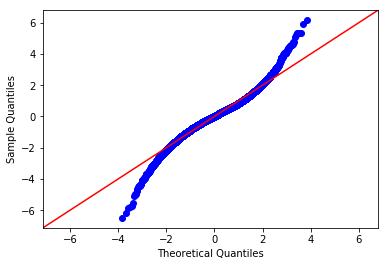

In [86]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

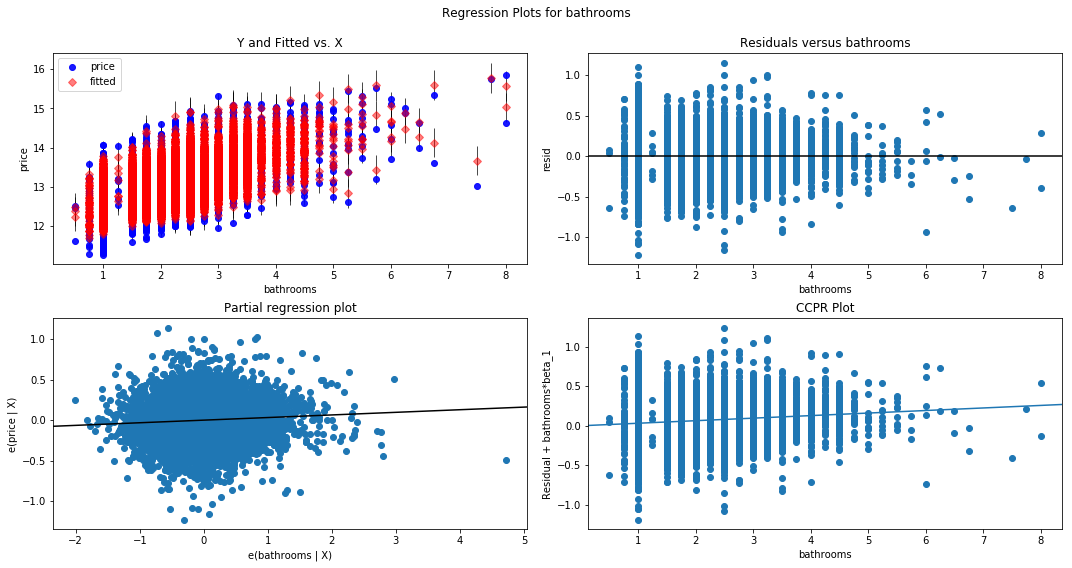

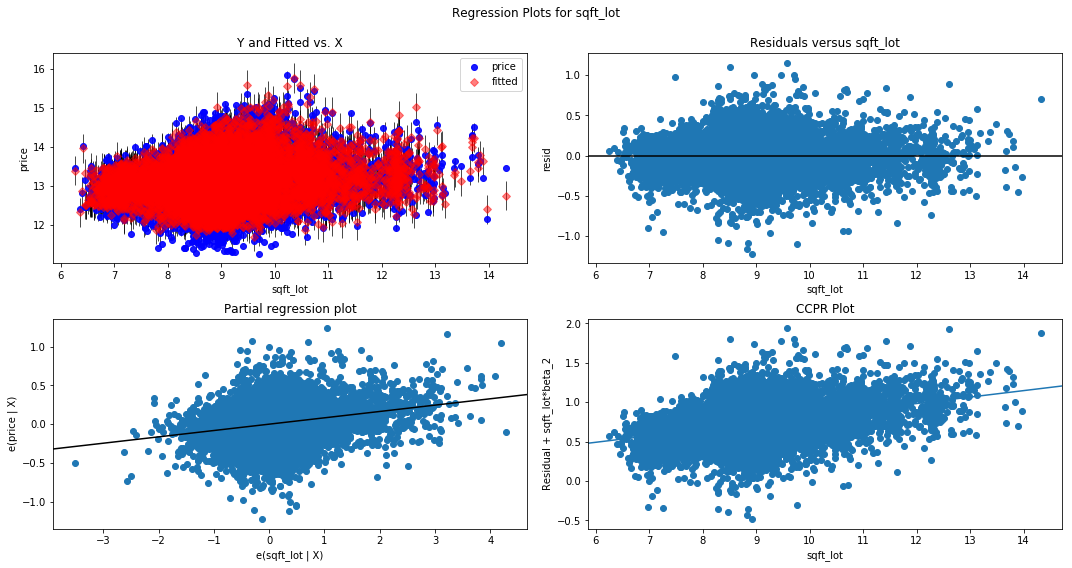

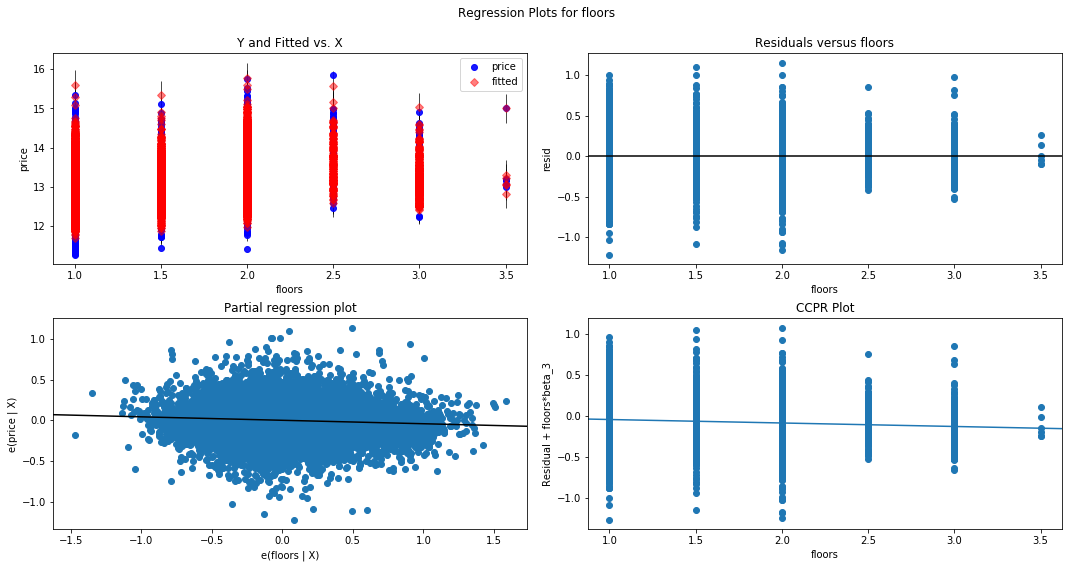

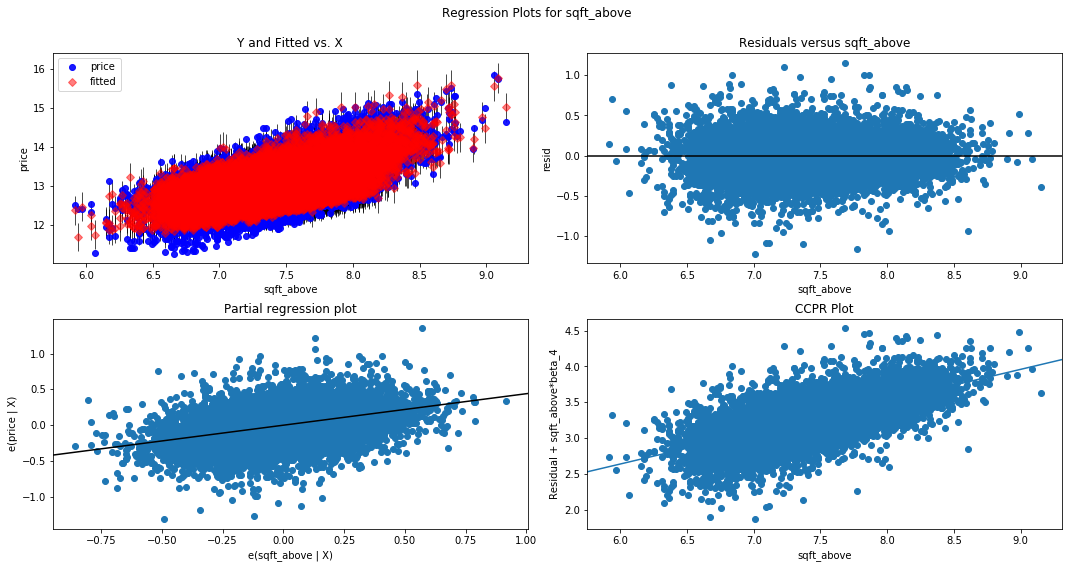

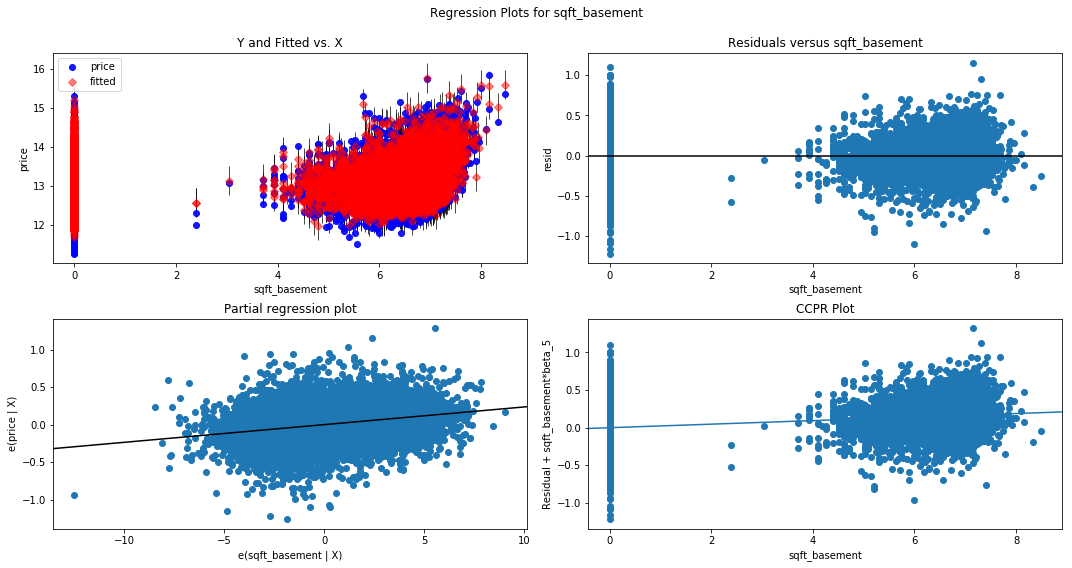

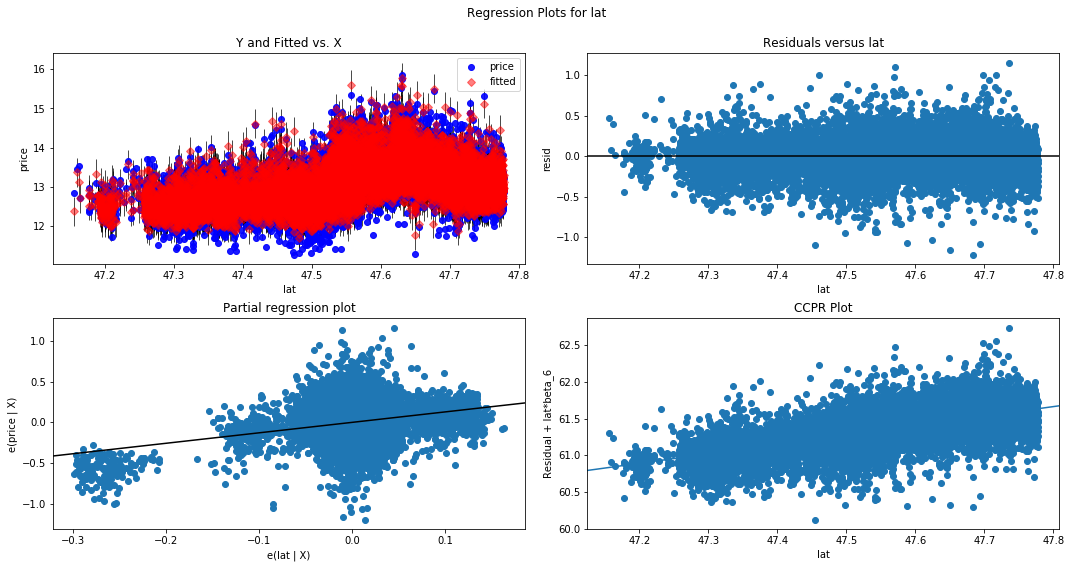

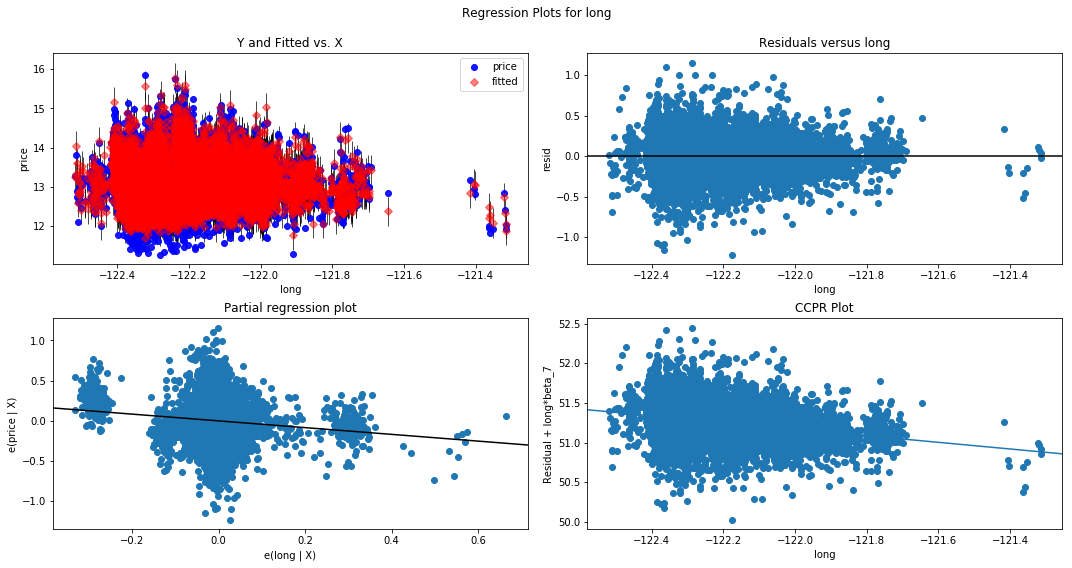

In [87]:
for col in ['bathrooms', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'lat', 'long']:
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()

### Take 6

- **Quantitative features:** ~~bedrooms~~, bathrooms, sqft_lot, floors, sqft_above, sqft_basement, lat, long
- **Categorical features:** waterfront, condition, grade, yr_renovated, yt_built, ~~zipcode~~
- **Notes:** log normalization: `price`, `sqft_above`, `sqft_basement`, `sqft_lot`, removed `zipcode`
- **Observations:** linearity slightly improved, but $R^2$ decreased from our best model
- **Results:**
  - $R^2 adj$: 0.772
  - MSE (train): 0.06357858262293843
  - MSE (test): 0.06826599960163006

In [44]:
X_train = X_train.drop(['zipcode', 'bedrooms', 'waterfront_0', 'condition_1', 'grade_3', 'yr_renovated_1944', 'yr_built_1900'],
                       axis=1)
X_test = X_test.drop(['zipcode', 'bedrooms', 'waterfront_0', 'condition_1', 'grade_3', 'yr_renovated_1944', 'yr_built_1900'],
                       axis=1)

In [45]:
predictors = sm.add_constant(X_train)
model = sm.OLS(y_train, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     285.2
Date:                Sun, 16 Jun 2019   Prob (F-statistic):               0.00
Time:                        12:01:09   Log-Likelihood:                -711.76
No. Observations:               17276   AIC:                             1832.
Df Residuals:                   17072   BIC:                             3414.
Df Model:                         203                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -51.5317      2.356    -21.876      0.000     -56.149     -46.914
bathrooms             0.0556      0.005     12.011      0.000       0.047       0.065
sqft_lot              0.0184      0.003      5.992      0.000       0.012       0.024
floors               -0.0094      0.006     -1.543      0.123      -0.021       0.003
sqft_above            0.3873      0.010     39.626      0.000       0.368       0.406
sqft_basement         0.0273      0.001     33.197      0.000       0.026       0.029
lat                   1.3311      0.015     87.514      0.000       1.301       1.361
long                  0.0129      0.018      0.732      0.464      -0.022       0.048
waterfront_1          0.6383      0.024     26.697      0.000       0.591       0.685
condition_2           0.1667      0.061      2.718      0.007       0.046       0.287
condition_3           0.2863      0.058      4.969      0.000       0.173       0.399
condition_4           0.3764      0.058      6.531      0.000       0.263       0.489
condition_5           0.4331      0.058      7.480      0.000       0.320       0.547
grade_10              0.3022      0.256      1.180      0.238      -0.200       0.804
grade_11              0.4767      0.256      1.859      0.063      -0.026       0.979
grade_12              0.7205      0.258      2.794      0.005       0.215       1.226
grade_13              0.9939      0.267      3.724      0.000       0.471       1.517
grade_4              -0.6714      0.261     -2.569      0.010      -1.184      -0.159
grade_5              -0.5951      0.256     -2.324      0.020      -1.097      -0.093
grade_6              -0.4701      0.256     -1.839      0.066      -0.971       0.031
grade_7              -0.2936      0.256     -1.149      0.251      -0.795       0.207
grade_8              -0.0996      0.256     -0.389      0.697      -0.601       0.402
grade_9               0.1188      0.256      0.464      0.643      -0.383       0.620
yr_built_1901        -0.0585      0.062     -0.951      0.342      -0.179       0.062
yr_built_1902        -0.0523      0.067     -0.783      0.434      -0.183       0.079
yr_built_1903        -0.1577      0.054     -2.913      0.004      -0.264      -0.052
yr_built_1904        -0.0345      0.052     -0.667      0.504      -0.136       0.067
yr_built_1905        -0.0333      0.045     -0.733      0.463      -0.122       0.056
yr_built_1906        -0.0149      0.043     -0.342      0.732      -0.100       0.070
yr_built_1907         0.0006      0.049      0.012      0.990      -0.095       0.096
yr_built_1908        -0.0957      0.044     -2.168      0.030      -0.182      -0.009
yr_built_1909        -0.0365      0.042     -0.859      0.390      -0.120       0.047
yr_built_1910        -0.0673      0.040     -1.701      0.089      -0.145

In [46]:
predictors_test = sm.add_constant(X_test)
y_hat_train = model.predict(predictors)
y_hat_test = model.predict(predictors_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.06357858262293843
Test Mean Squarred Error: 0.06826599960163006


C:\Data\Python37\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


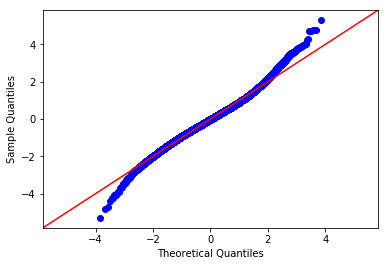

In [47]:
residuals = model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

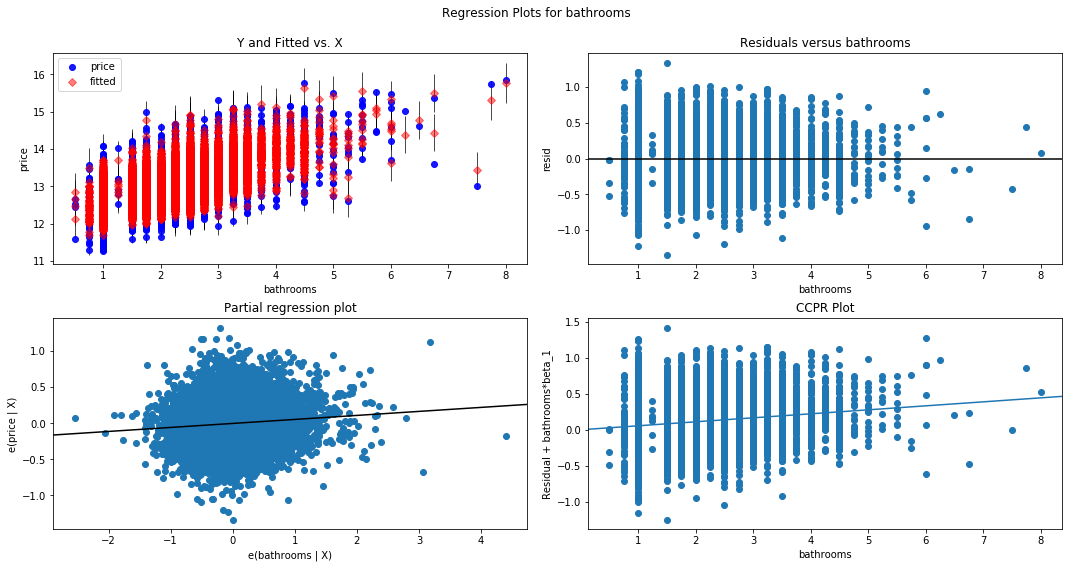

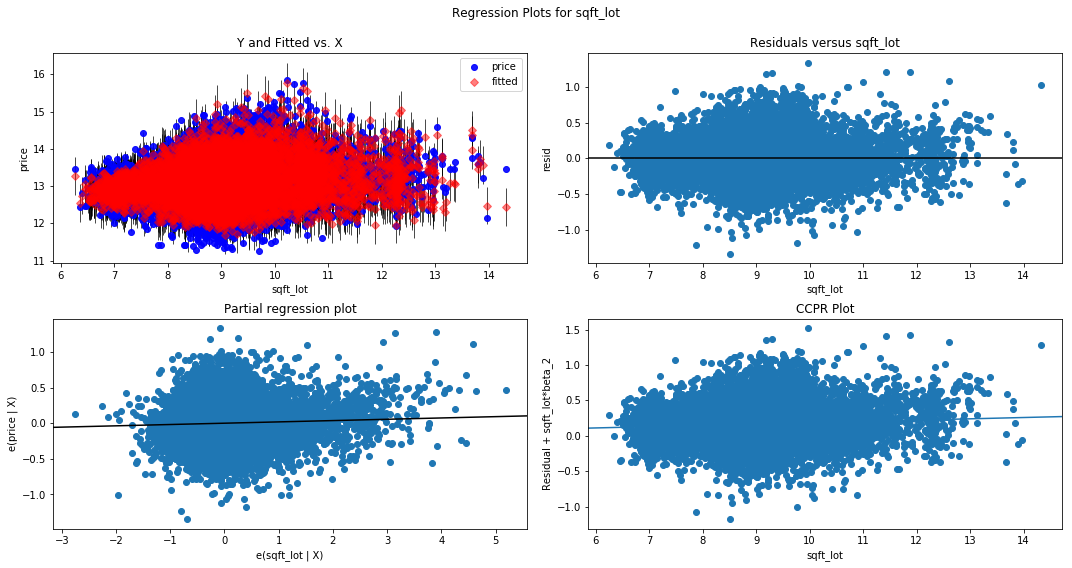

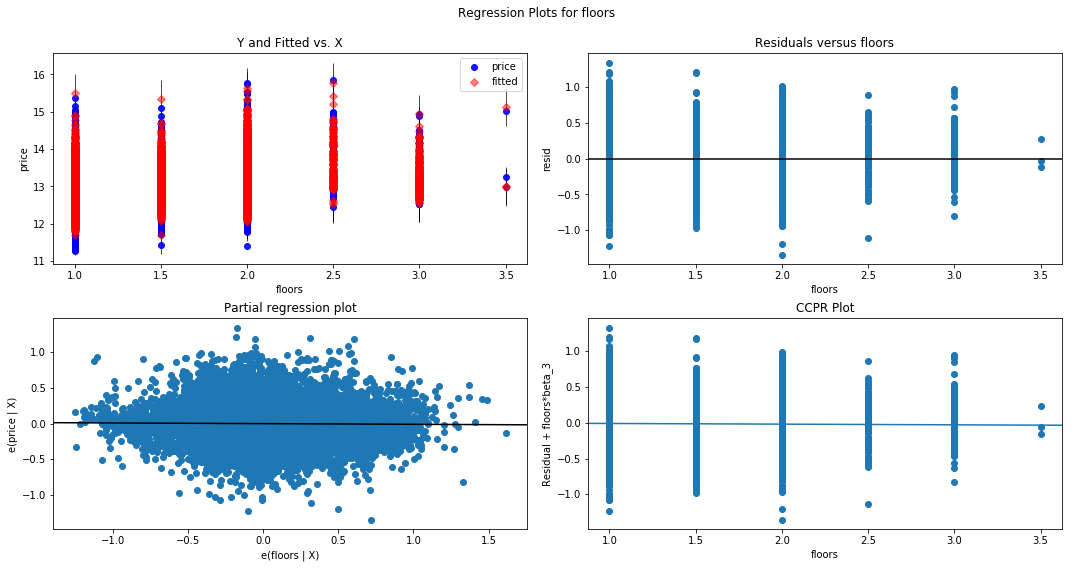

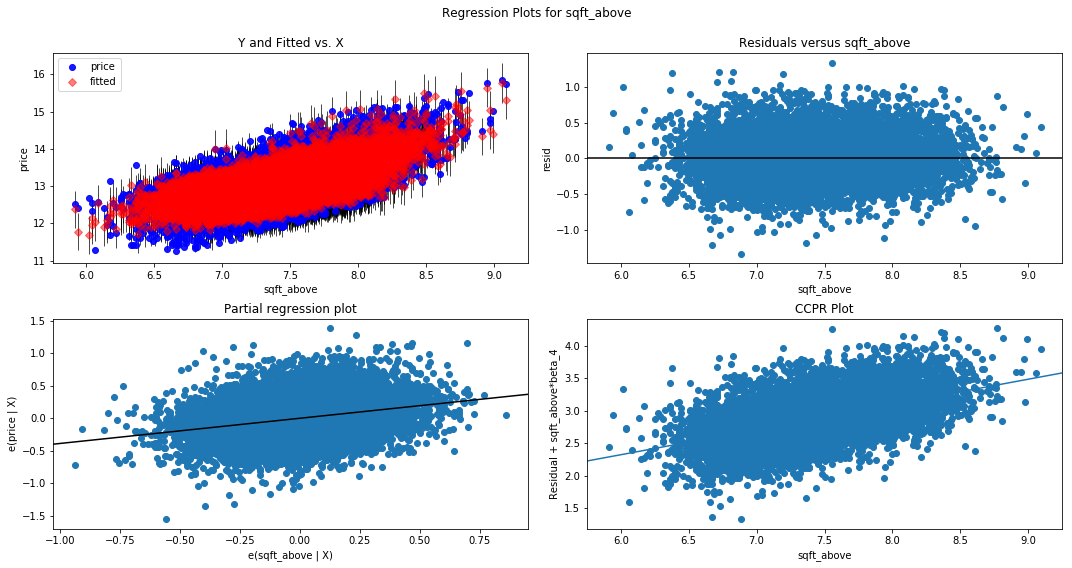

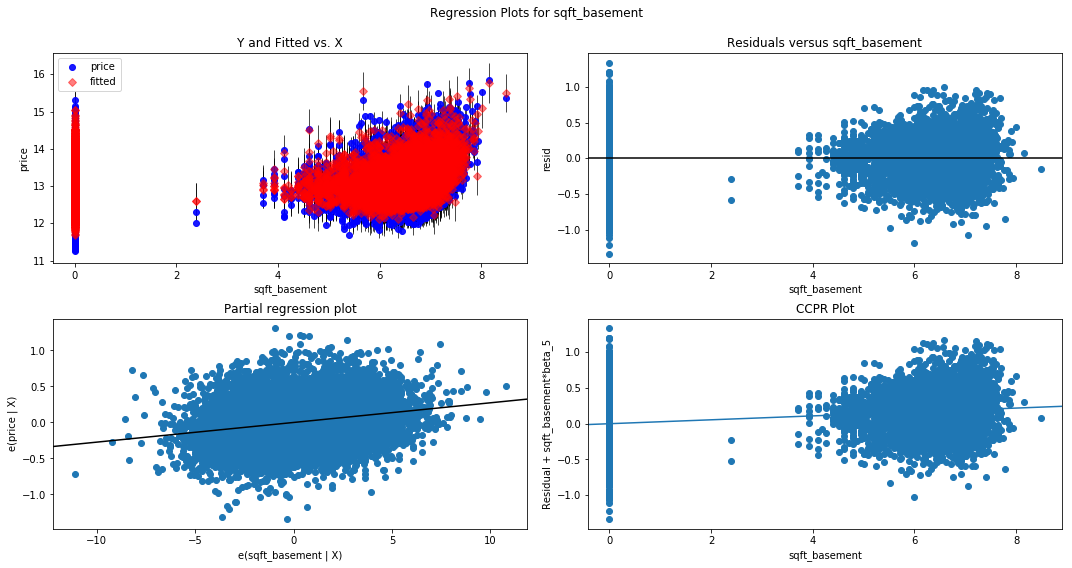

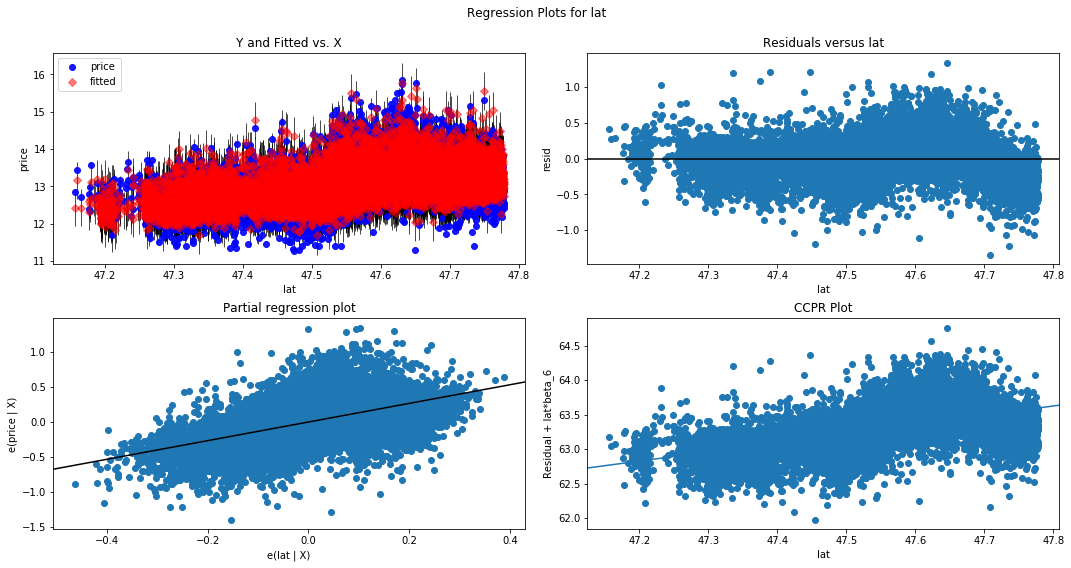

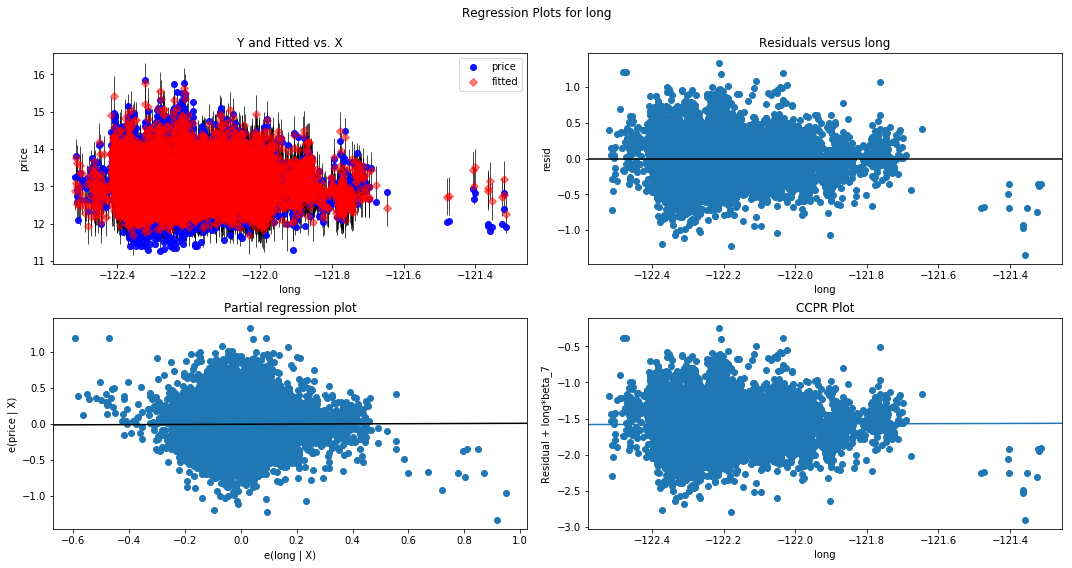

In [48]:
for col in ['bathrooms', 'sqft_lot', 'floors', 'sqft_above', 'sqft_basement', 'lat', 'long']:
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()

## 4. Interpretation